# Workshop 2 - Data Preparation 




<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Join" data-toc-modified-id="Join-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Join</a></span><ul class="toc-item"><li><span><a href="#Join-with-time-series" data-toc-modified-id="Join-with-time-series-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Join with time series</a></span></li></ul></li><li><span><a href="#Duplicates" data-toc-modified-id="Duplicates-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Duplicates</a></span></li><li><span><a href="#Missing-Values" data-toc-modified-id="Missing-Values-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Missing Values</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Outliers</a></span></li><li><span><a href="#Encoding" data-toc-modified-id="Encoding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Encoding</a></span></li><li><span><a href="#Decomposition" data-toc-modified-id="Decomposition-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Decomposition</a></span><ul class="toc-item"><li><span><a href="#PCA-:-Principal-Component-Analysis" data-toc-modified-id="PCA-:-Principal-Component-Analysis-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>PCA : Principal Component Analysis</a></span></li><li><span><a href="#MCA-:-Multiple-Correspondence-Analysis" data-toc-modified-id="MCA-:-Multiple-Correspondence-Analysis-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>MCA : Multiple Correspondence Analysis</a></span></li></ul></li><li><span><a href="#Normalization" data-toc-modified-id="Normalization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Data-Balancing" data-toc-modified-id="Data-Balancing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Data Balancing</a></span></li></ul></div>

<div class="alert alert-block alert-warning">
The main goal of this workshop is not to conduct the right data preparation to train a model. Our scope is to explore the maximum of VerticaPy features and tools.

The right steps and functions for data preparation are left to the user's judgment based on the case.
</div>

As we saw in the previous workshop we can load CSV files to the database. We will load 3 datasets to the database to conduct joins among them. Some case you need to use more than one dataset and the join operation is extremely useful to have more information. 

Let's use the [US flights 2015 datasets](https://www.kaggle.com/datasets/usdot/flight-delays)

In [1]:
import verticapy as vp
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext verticapy.sql

In [2]:
STYLE = 'ggplot'
COLOR = '#66b3ff'
# you can chooss the style
plt.style.use(STYLE)
# Connect with the database
vp.connect("tutorial_connection")
# Create VerticaPy schema for native verticapy models
vp.create_verticapy_schema()

In [3]:
try:
    # Load all the datasets to db
    vp.read_csv("data/flights.csv",
                schema='public',
                table_name='flights')
    # Read data
    flights = vp.vDataFrame("public.flights")

    vp.read_csv("data/airports.csv",
                schema='public',
                table_name='airports')
    # Read data
    airports = vp.vDataFrame("public.airports")

    vp.read_csv("data/airlines.csv",
                schema='public',
                table_name='airlines')
    # Read data
    airlines = vp.vDataFrame("public.airlines")
except:
    # Read data
    flights = vp.vDataFrame("public.flights")
    airlines = vp.vDataFrame("public.airlines")
    airports = vp.vDataFrame("public.airports")

YEAR    MONTH    DAY    DAY_OF_WEEK    AIRLINE    FLIGHT_NUMBER    TAIL_NUMBER   \\
1    2015        3     10              2         DL             2666         N967AT   \\
2    2015        3     10              2         DL             2667         N975AT   \\
3    2015        3     10              2         DL             2668         N994AT   \\
     ORIGIN_AIRPORT    DESTINATION_AIRPORT    SCHEDULED_DEPARTURE    DEPARTURE_TIME    DEPARTURE_DELAY   \\
1               LGA                    BOS                    600               553                 -7   \\
2               BOS                    LGA                    700               659                 -1   \\
3               LGA                    BOS                    700               658                 -2   \\
     TAXI_OUT    WHEELS_OFF    SCHEDULED_TIME    ELAPSED_TIME    AIR_TIME    DISTANCE   \\
1          18           611                67              64          41         184   \\
2          35           734                79             101          49         184   \\
3          20           718                74              68          42         184   \\
     WHEELS_ON    TAXI_IN    SCHEDULED_ARRIVAL    ARRIVAL_TIME    ARRIVAL_DELAY    DIVERTED   \\
1          652          5                  707             657              -10           0   \\
2          823         17                  819             840               21           0   \\
3          800          6                  814             806               -8           0   \\
     CANCELLED    CANCELLATION_REASON    AIR_SYSTEM_DELAY    SECURITY_DELAY    AIRLINE_DELAY   \\
1            0                   None                None              None             None   \\
2            0                   None                  21                 0                0   \\
3            0                   None                None              None             None   \\
     LATE_AIRCRAFT_DELAY    WEATHER_DELAY  
1                   None             None  
2                      0                0  
3                   None             None  
Rows: 1-3 | Columns: 31
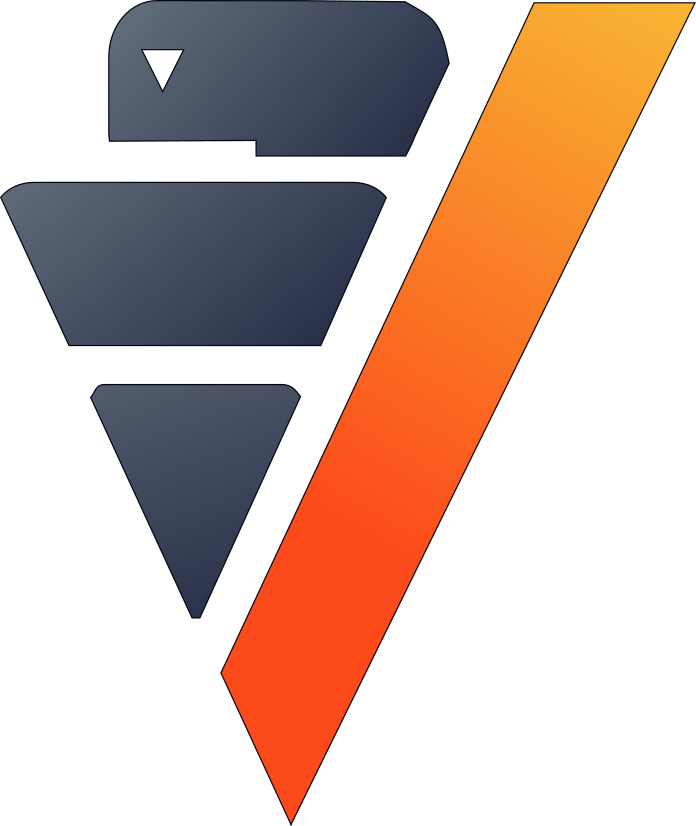

In [4]:
# Display flights data
flights.head(3)

IATA_CODE                   AIRLINE  
1           AA    American Airlines Inc.  
2           AS      Alaska Airlines Inc.  
3           B6           JetBlue Airways  
Rows: 1-3 | Columns: 2
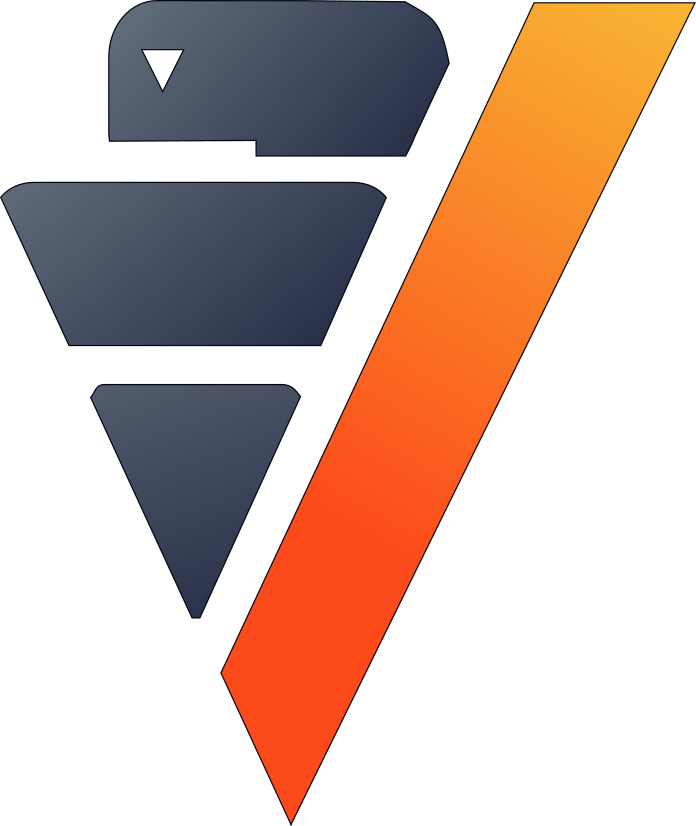

In [5]:
# display airlines data
airlines.head(3)

IATA_CODE                                AIRPORT           CITY    STATE    COUNTRY    LATITUDE   \\
1          ABE    Lehigh Valley International Airport      Allentown       PA        USA    40.65236   \\
2          ABI               Abilene Regional Airport        Abilene       TX        USA    32.41132   \\
3          ABQ      Albuquerque International Sunport    Albuquerque       NM        USA    35.04022   \\
      LONGITUDE  
1      -75.4404  
2      -99.6819  
3    -106.60919  
Rows: 1-3 | Columns: 7
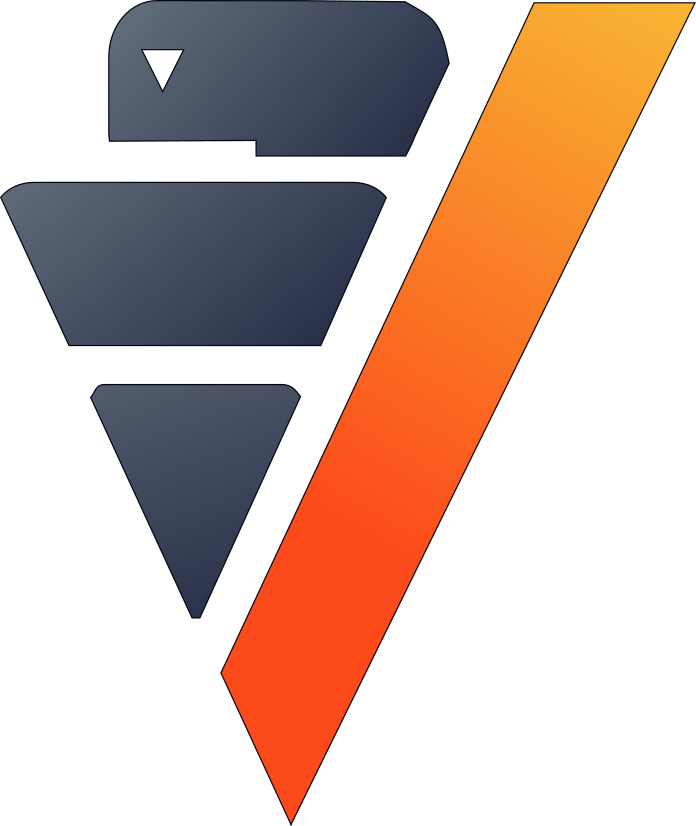

In [6]:
# display airports data
airports.head(3)

## Join
Each dataset has a primary or secondary key on which to join the data. For instance, we can join all the datasets using `IATA_CODE`.

The [`join`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/join/index.php) function provides different type of joins: _left, right, cross, full, natural, and inner_.


YEAR    MONTH    DAY    DAY_OF_WEEK    AIRLINE    FLIGHT_NUMBER    TAIL_NUMBER   \\
1    2015        1      1              4         AA                1         N787AA   \\
2    2015        1      1              4         AA                2         N795AA   \\
3    2015        1      1              4         AA                3         N798AA   \\
4    2015        1      1              4         AA                4         N799AA   \\
5    2015        1      1              4         AA                5         N376AA   \\
     ORIGIN_AIRPORT    DESTINATION_AIRPORT    SCHEDULED_DEPARTURE    DEPARTURE_TIME    DEPARTURE_DELAY   \\
1               JFK                    LAX                    900               855                 -5   \\
2               LAX                    JFK                    900               856                 -4   \\
3               JFK                    LAX                   1230              1226                 -4   \\
4               LAX                    JFK                   1220              1214                 -6   \\
5               DFW                    HNL                   1305              1754                289   \\
     TAXI_OUT    WHEELS_OFF    SCHEDULED_TIME    ELAPSED_TIME    AIR_TIME    DISTANCE   \\
1          17           912               390             402         378        2475   \\
2          16           912               335             295         271        2475   \\
3          19          1245               380             382         358        2475   \\
4          23          1237               330             319         284        2475   \\
5          21          1815               515             526         499        3784   \\
     WHEELS_ON    TAXI_IN    SCHEDULED_ARRIVAL    ARRIVAL_TIME    ARRIVAL_DELAY    DIVERTED   \\
1         1230          7                 1230            1237                7           0   \\
2         1643          8                 1735            1651              -44           0   \\
3         1543          5                 1550            1548               -2           0   \\
4         2021         12                 2050            2033              -17           0   \\
5         2234          6                 1740            2240              300           0   \\
     CANCELLED    CANCELLATION_REASON    AIR_SYSTEM_DELAY    SECURITY_DELAY    AIRLINE_DELAY   \\
1            0                   None                None              None             None   \\
2            0                   None                None              None             None   \\
3            0                   None                None              None             None   \\
4            0                   None                None              None             None   \\
5            0                   None                  11                 0              197   \\
     LATE_AIRCRAFT_DELAY    WEATHER_DELAY              airline_long  
1                   None             None    American Airlines Inc.  
2                   None             None    American Airlines Inc.  
3                   None             None    American Airlines Inc.  
4                   None             None    American Airlines Inc.  
5                     92                0    American Airlines Inc.  
Rows: 1-5 | Columns: 32
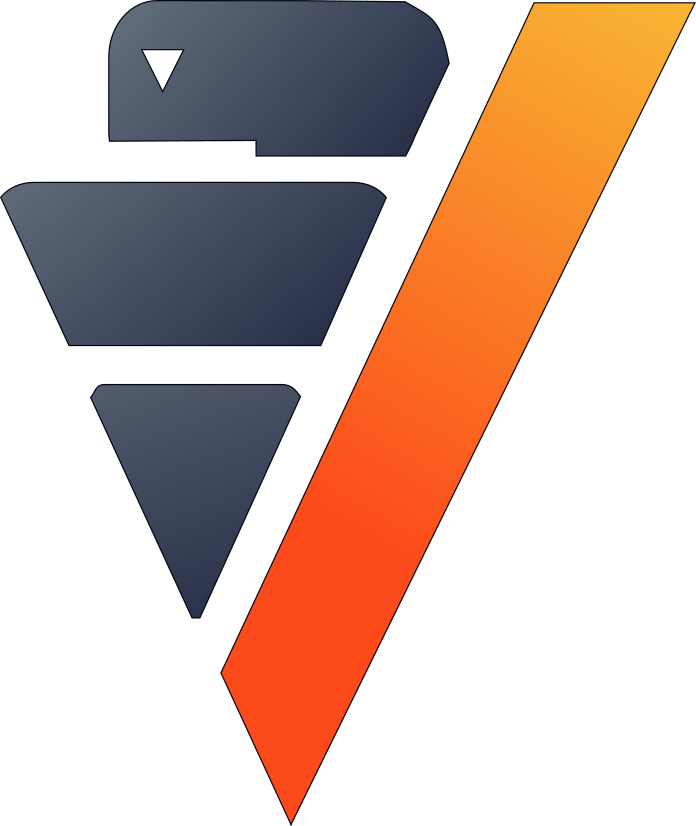

In [7]:
# Left join on filghts and airlines
flights = flights.join(airlines,
                       how='left',
                       on={"AIRLINE": "IATA_CODE"},
                       expr2=["AIRLINE AS airline_long"])
flights.head(5)

### Join with time series
We can also join multiple data with respect to time-stamp using interpolation. 

You can find the datasets [here](https://www.vertica.com/python/examples/smart_meters/index.php)

In [8]:
try:
    vp.read_csv("data/sm_consumption.csv",
                table_name='sm_consumption',
                schema="public")
    vp.read_csv("data/sm_weather.csv",
                table_name="sm_weather",
                schema="public")

    sm_consumption = vp.vDataFrame("public.sm_consumption")
    sm_weather = vp.vDataFrame("public.sm_weather")

except:
    sm_consumption = vp.vDataFrame("public.sm_consumption")
    sm_weather = vp.vDataFrame("public.sm_weather")

meterID                dateUTC     value  
1            0    2014-01-01 11:00:00     0.029  
2            0    2014-01-01 13:45:00     0.277  
3            0    2014-01-02 10:45:00     0.321  
4            0    2014-01-02 11:15:00     0.305  
5            0    2014-01-02 13:45:00     0.358  
6            0    2014-01-02 15:30:00     0.115  
7            0    2014-01-03 08:30:00     0.071  
8            0    2014-01-04 23:45:00     0.323  
9            0    2014-01-06 01:15:00     0.085  
10           0    2014-01-06 21:45:00     0.713  
11           0    2014-01-07 00:15:00     0.242  
12           0    2014-01-07 23:00:00      0.09  
13           0    2014-01-09 05:30:00     0.115  
14           0    2014-01-09 15:00:00     0.928  
15           0    2014-01-09 18:15:00      1.09  
16           0    2014-01-10 10:00:00      0.07  
17           0    2014-01-10 14:30:00    10.832  
18           0    2014-01-10 15:30:00     3.288  
19           0    2014-01-10 18:00:00      0.42  
20           0    2014-01-11 10:45:00     1.045  
21           0    2014-01-12 07:45:00     0.091  
22           0    2014-01-13 19:45:00     0.249  
23           0    2014-01-13 20:15:00      0.34  
24           0    2014-01-14 13:00:00     0.099  
25           0    2014-01-14 14:00:00       0.2  
26           0    2014-01-14 14:45:00     0.865  
27           0    2014-01-14 22:00:00     0.716  
28           0    2014-01-15 03:45:00      0.05  
29           0    2014-01-15 11:15:00     0.052  
30           0    2014-01-15 11:30:00     0.038  
31           0    2014-01-15 23:15:00     0.239  
32           0    2014-01-16 19:30:00     1.422  
33           0    2014-01-17 15:00:00     0.291  
34           0    2014-01-18 00:30:00     0.828  
35           0    2014-01-19 03:00:00     0.017  
36           0    2014-01-19 05:30:00     0.024  
37           0    2014-01-19 06:15:00     0.048  
38           0    2014-01-19 15:30:00      13.3  
39           0    2014-01-20 19:30:00      0.59  
40           0    2014-01-21 12:30:00     0.327  
41           0    2014-01-21 13:30:00     0.108  
42           0    2014-01-22 01:30:00     0.083  
43           0    2014-01-22 04:30:00     0.044  
44           0    2014-01-23 21:00:00     0.226  
45           0    2014-01-24 02:00:00     0.125  
46           0    2014-01-24 12:15:00     0.168  
47           0    2014-01-27 22:45:00     0.495  
48           0    2014-01-28 06:15:00     0.056  
49           0    2014-01-28 11:30:00     0.113  
50           0    2014-01-28 19:00:00     1.566  
51           0    2014-01-28 19:45:00     1.108  
52           0    2014-01-29 05:00:00     0.064  
53           0    2014-01-29 07:45:00     0.145  
54           0    2014-01-29 13:00:00     1.719  
55           0    2014-01-30 06:15:00     0.059  
56           0    2014-01-30 17:45:00     0.575  
57           0    2014-01-30 18:45:00     1.129  
58           0    2014-02-01 03:30:00     0.057  
59           0    2014-02-01 03:45:00     0.059  
60           0    2014-02-02 08:45:00     0.186  
61           0    2014-02-04 03:45:00     0.045  
62           0    2014-02-04 12:00:00     0.187  
63           0    2014-02-04 16:00:00     0.313  
64           0    2014-02-04 18:45:00     0.912  
65           0    2014-02-05 06:45:00     0.018  
66           0    2014-02-05 17:15:00     0.112  
67           0    2014-02-06 15:15:00    10.146  
68           0    2014-02-07 11:00:00     0.868  
69           0    2014-02-07 17:30:00     3.812  
70           0    2014-02-07 22:15:00     1.262  
71           0    2014-02-08 03:45:00     0.043  
72           0    2014-02-08 06:45:00     0.106  
73           0    2014-02-09 04:15:00     0.449  
74           0    2014-02-09 08:30:00     0.007  
75           0    2014-02-11 02:30:00     0.087  
76           0    2014-02-11 05:30:00     0.039  
77           0    2014-02-11 19:00:00     0.094  
78           0    2014-02-12 02:30:00     0.102  
79           0    2014-02-13 02:45:00     0.097  
80     
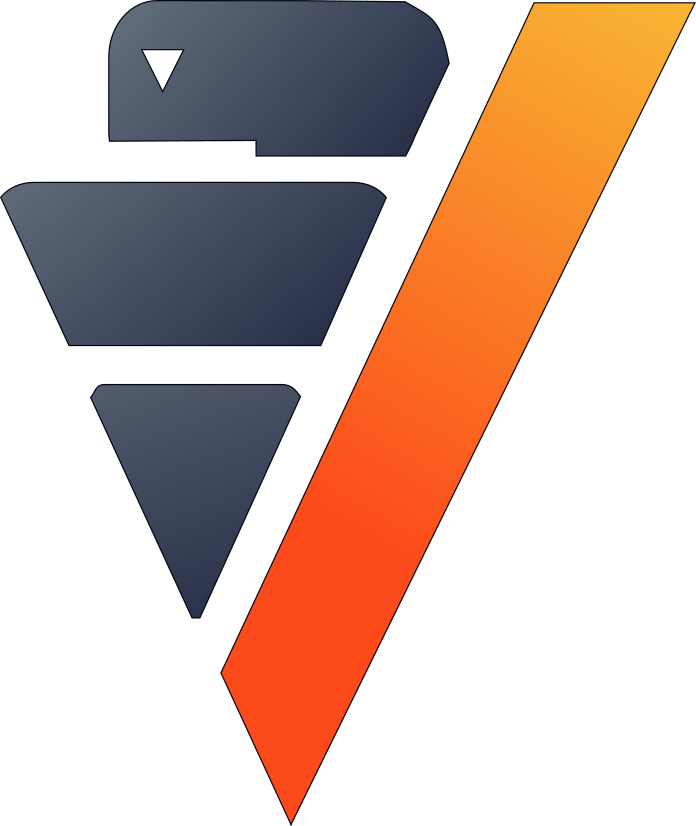

dateUTC    temperature    humidity  
1      2014-01-01 00:00:00           38.0        95.0  
2      2014-01-01 00:30:00           37.4        93.0  
3      2014-01-01 01:00:00           37.4       100.0  
4      2014-01-01 01:30:00           37.4       100.0  
5      2014-01-01 02:00:00           39.2        93.0  
6      2014-01-01 02:30:00           39.2        93.0  
7      2014-01-01 03:00:00           39.2        93.0  
8      2014-01-01 03:30:00           39.2        93.0  
9      2014-01-01 04:00:00           39.2        93.0  
10     2014-01-01 04:30:00           39.2        93.0  
11     2014-01-01 05:00:00           39.2        93.0  
12     2014-01-01 05:30:00           39.2        87.0  
13     2014-01-01 06:00:00           38.0        89.0  
14     2014-01-01 06:30:00           37.4        93.0  
15     2014-01-01 07:00:00           37.4        93.0  
16     2014-01-01 07:30:00           37.4        93.0  
17     2014-01-01 08:00:00           37.4        93.0  
18     2014-01-01 08:30:00           37.4        87.0  
19     2014-01-01 09:00:00           37.4        87.0  
20     2014-01-01 09:30:00           37.4        87.0  
21     2014-01-01 10:00:00           37.4        93.0  
22     2014-01-01 10:30:00           37.4        93.0  
23     2014-01-01 11:00:00           37.4        87.0  
24     2014-01-01 11:30:00           37.4        93.0  
25     2014-01-01 12:00:00           38.0        85.0  
26     2014-01-01 12:30:00           39.2        87.0  
27     2014-01-01 13:00:00           39.2        87.0  
28     2014-01-01 13:30:00           39.2        87.0  
29     2014-01-01 14:00:00           39.2        87.0  
30     2014-01-01 14:30:00           39.2        87.0  
31     2014-01-01 15:00:00           39.2        87.0  
32     2014-01-01 15:30:00           39.2        87.0  
33     2014-01-01 16:00:00           37.4        93.0  
34     2014-01-01 16:30:00           39.2        87.0  
35     2014-01-01 17:00:00           39.2        87.0  
36     2014-01-01 17:30:00           37.4        87.0  
37     2014-01-01 18:00:00           38.0        81.0  
38     2014-01-01 18:30:00           37.4        87.0  
39     2014-01-01 19:00:00           35.6        87.0  
40     2014-01-01 19:30:00           37.4        93.0  
41     2014-01-01 20:00:00           39.2        87.0  
42     2014-01-01 20:30:00           39.2        87.0  
43     2014-01-01 21:00:00           39.2        87.0  
44     2014-01-01 21:30:00           41.0        81.0  
45     2014-01-01 22:00:00           39.2        87.0  
46     2014-01-01 22:30:00           39.2        87.0  
47     2014-01-01 23:00:00           39.2        87.0  
48     2014-01-01 23:30:00           39.2        81.0  
49     2014-01-02 00:00:00           38.0        76.0  
50     2014-01-02 00:30:00           37.4        81.0  
51     2014-01-02 01:00:00           37.4        81.0  
52     2014-01-02 01:30:00           37.4        81.0  
53     2014-01-02 02:00:00           37.4        81.0  
54     2014-01-02 02:30:00           37.4        81.0  
55     2014-01-02 03:00:00           37.4        81.0  
56     2014-01-02 03:30:00           37.4        81.0  
57     2014-01-02 04:00:00           37.4        81.0  
58     2014-01-02 04:30:00           35.6        87.0  
59     2014-01-02 05:00:00           35.6        93.0  
60     2014-01-02 05:30:00           37.4        81.0  
61     2014-01-02 06:00:00           37.0        75.0  
62     2014-01-02 06:30:00           37.4        81.0  
63     2014-01-02 07:00:00           37.4        87.0  
64     2014-01-02 07:30:00           37.4        81.0  
65     2014-01-02 08:00:00           35.6        81.0  
66     2014-01-02 08:30:00           35.6        81.0  
67     2014-01-02 09:00:00           37.4        75.0  
68     2014-01-02 09:30:00           37.4        81.0  
69     2014-01-02 10:00:00           39.2        75.0  
70     2014-01-02 10:30:00           41.0        70.0  
71     2014-01-02 11:00:00           39.2  
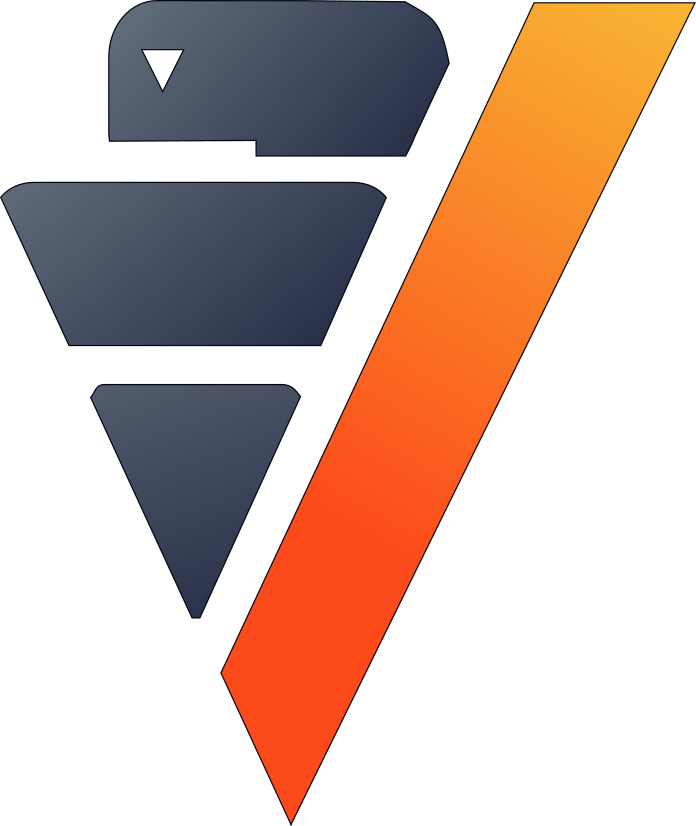

In [9]:
display(sm_consumption)
display(sm_weather)

Consumption data has lot of gaps, we will slice and interpolate the energy consumption every 30 minutes using [`interpolate`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/interpolate/) which is a powerful tool in time series data.

dateUTC    meterID                 value  
1      2014-01-01 11:00:00          0                 0.029  
2      2014-01-01 11:30:00          0    0.0740909090909091  
3      2014-01-01 12:00:00          0     0.119181818181818  
4      2014-01-01 12:30:00          0     0.164272727272727  
5      2014-01-01 13:00:00          0     0.209363636363636  
6      2014-01-01 13:30:00          0     0.254454545454545  
7      2014-01-01 14:00:00          0      0.27752380952381  
8      2014-01-01 14:30:00          0     0.278571428571429  
9      2014-01-01 15:00:00          0     0.279619047619048  
10     2014-01-01 15:30:00          0     0.280666666666667  
11     2014-01-01 16:00:00          0     0.281714285714286  
12     2014-01-01 16:30:00          0     0.282761904761905  
13     2014-01-01 17:00:00          0     0.283809523809524  
14     2014-01-01 17:30:00          0     0.284857142857143  
15     2014-01-01 18:00:00          0     0.285904761904762  
16     2014-01-01 18:30:00          0     0.286952380952381  
17     2014-01-01 19:00:00          0                 0.288  
18     2014-01-01 19:30:00          0     0.289047619047619  
19     2014-01-01 20:00:00          0     0.290095238095238  
20     2014-01-01 20:30:00          0     0.291142857142857  
21     2014-01-01 21:00:00          0     0.292190476190476  
22     2014-01-01 21:30:00          0     0.293238095238095  
23     2014-01-01 22:00:00          0     0.294285714285714  
24     2014-01-01 22:30:00          0     0.295333333333333  
25     2014-01-01 23:00:00          0     0.296380952380952  
26     2014-01-01 23:30:00          0     0.297428571428571  
27     2014-01-02 00:00:00          0     0.298476190476191  
28     2014-01-02 00:30:00          0      0.29952380952381  
29     2014-01-02 01:00:00          0     0.300571428571429  
30     2014-01-02 01:30:00          0     0.301619047619048  
31     2014-01-02 02:00:00          0     0.302666666666667  
32     2014-01-02 02:30:00          0     0.303714285714286  
33     2014-01-02 03:00:00          0     0.304761904761905  
34     2014-01-02 03:30:00          0     0.305809523809524  
35     2014-01-02 04:00:00          0     0.306857142857143  
36     2014-01-02 04:30:00          0     0.307904761904762  
37     2014-01-02 05:00:00          0     0.308952380952381  
38     2014-01-02 05:30:00          0                  0.31  
39     2014-01-02 06:00:00          0     0.311047619047619  
40     2014-01-02 06:30:00          0     0.312095238095238  
41     2014-01-02 07:00:00          0     0.313142857142857  
42     2014-01-02 07:30:00          0     0.314190476190476  
43     2014-01-02 08:00:00          0     0.315238095238095  
44     2014-01-02 08:30:00          0     0.316285714285714  
45     2014-01-02 09:00:00          0     0.317333333333333  
46     2014-01-02 09:30:00          0     0.318380952380952  
47     2014-01-02 10:00:00          0     0.319428571428571  
48     2014-01-02 10:30:00          0      0.32047619047619  
49     2014-01-02 11:00:00          0                 0.313  
50     2014-01-02 11:30:00          0                0.3103  
51     2014-01-02 12:00:00          0                0.3209  
52     2014-01-02 12:30:00          0                0.3315  
53     2014-01-02 13:00:00          0                0.3421  
54     2014-01-02 13:30:00          0                0.3527  
55     2014-01-02 14:00:00          0     0.323285714285714  
56     2014-01-02 14:30:00          0     0.253857142857143  
57     2014-01-02 15:00:00          0     0.184428571428571  
58     2014-01-02 15:30:00          0                 0.115  
59     2014-01-02 16:00:00          0     0.113705882352941  
60     2014-01-02 16:30:00          0     0.112411764705882  
61     2014-01-02 17:00:00          0     0.111117647058824  
62     2014-01-02 17:30:00          0     0.109823529411765  
63     2014-01-02 18:00:00          0     0.108529411764706  
64     2014-01-02 18:30:00          0     0.1072352
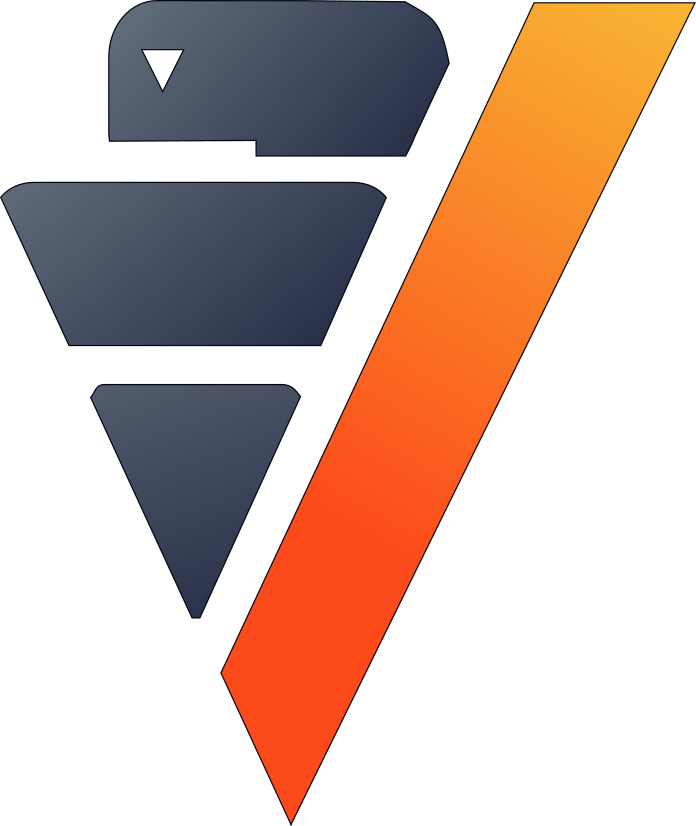

In [10]:
# Slicing and interpolation data with 30 min interval
interpolated_sm_consumption = sm_consumption.interpolate(ts="dateUTC",
                                                         rule="30 minutes",
                                                         method={
                                                             "value": "linear"},
                                                         by=["meterID"])
display(interpolated_sm_consumption)

In [11]:
# SQL query used to conduct the interpolation in vertica db
print(interpolated_sm_consumption.current_relation())

(
   SELECT
     "dateUTC",
     "meterID",
     "value" 
   FROM
 (
   SELECT
     slice_time AS "dateUTC",
     "meterID",
     TS_FIRST_VALUE("value", 'linear') AS "value" 
   FROM
 "public"."sm_consumption" TIMESERIES slice_time AS '30 minutes' OVER (PARTITION BY "meterID" ORDER BY "dateUTC"::timestamp)) interpolate) 
VERTICAPY_SUBTABLE


dateUTC    meterID                 value    temperature    humidity  
1      2014-02-04 03:30:00          0    0.0458197674418605           37.4        93.0  
2      2014-02-04 04:00:00          0    0.0493030303030303           37.4        93.0  
3      2014-02-04 04:30:00          0    0.0579090909090909           37.4        93.0  
4      2014-02-04 05:00:00          0    0.0665151515151515           37.4        93.0  
5      2014-02-04 05:30:00          0    0.0751212121212121           37.4        93.0  
6      2014-02-04 06:00:00          0    0.0837272727272727           37.0        92.0  
7      2014-02-04 06:30:00          0    0.0923333333333333           37.4        93.0  
8      2014-02-04 07:00:00          0     0.100939393939394           37.4        93.0  
9      2014-02-04 07:30:00          0     0.109545454545455           37.4        93.0  
10     2014-02-04 08:00:00          0     0.118151515151515           37.4        93.0  
11     2014-02-04 08:30:00          0     0.126757575757576           37.4        93.0  
12     2014-02-04 09:00:00          0     0.135363636363636           37.4        93.0  
13     2014-02-04 09:30:00          0     0.143969696969697           39.2        87.0  
14     2014-02-04 10:00:00          0     0.152575757575758           39.2        81.0  
15     2014-02-04 10:30:00          0     0.161181818181818           39.2        87.0  
16     2014-02-04 11:00:00          0     0.169787878787879           39.2        87.0  
17     2014-02-04 11:30:00          0     0.178393939393939           39.2        81.0  
18     2014-02-04 12:00:00          0                 0.187           39.0        76.0  
19     2014-02-04 12:30:00          0               0.20275           39.2        81.0  
20     2014-02-04 13:00:00          0                0.2185           39.2        81.0  
21     2014-02-04 13:30:00          0               0.23425           39.2        81.0  
22     2014-02-04 14:00:00          0                  0.25           39.2        87.0  
23     2014-02-04 14:30:00          0               0.26575           41.0        76.0  
24     2014-02-04 15:00:00          0                0.2815           39.2        81.0  
25     2014-02-04 15:30:00          0               0.29725           39.2        81.0  
26     2014-02-04 16:00:00          0                 0.313           39.2        81.0  
27     2014-02-04 16:30:00          0     0.421909090909091           39.2        81.0  
28     2014-02-04 17:00:00          0     0.530818181818182           39.2        81.0  
29     2014-02-04 17:30:00          0     0.639727272727273           37.4        87.0  
30     2014-02-04 18:00:00          0     0.748636363636364           36.0        81.0  
31     2014-02-04 18:30:00          0     0.857545454545455           35.6        87.0  
32     2014-02-04 19:00:00          0              0.893375           35.6        81.0  
33     2014-02-04 19:30:00          0              0.856125           33.8        87.0  
34     2014-02-04 20:00:00          0              0.818875           33.8        87.0  
35     2014-02-04 20:30:00          0              0.781625           33.8        93.0  
36     2014-02-04 21:00:00          0              0.744375           35.6        87.0  
37     2014-02-04 21:30:00          0              0.707125           35.6        87.0  
38     2014-02-04 22:00:00          0              0.669875           35.6        93.0  
39     2014-02-04 22:30:00          0              0.632625           35.6        87.0  
40     2014-02-04 23:00:00          0              0.595375           35.6        87.0  
41     2014-02-04 23:30:00          0              0.558125           35.6        87.0  
42     2014-02-05 00:00:00          0              0.520875           34.0        84.0  
43     2014-02-05 00:30:00          0              0.483625           33.8        87.0  
44     2014-02-05 01:00:00          0              0.446375           33.8        93.0  
45     2014-02
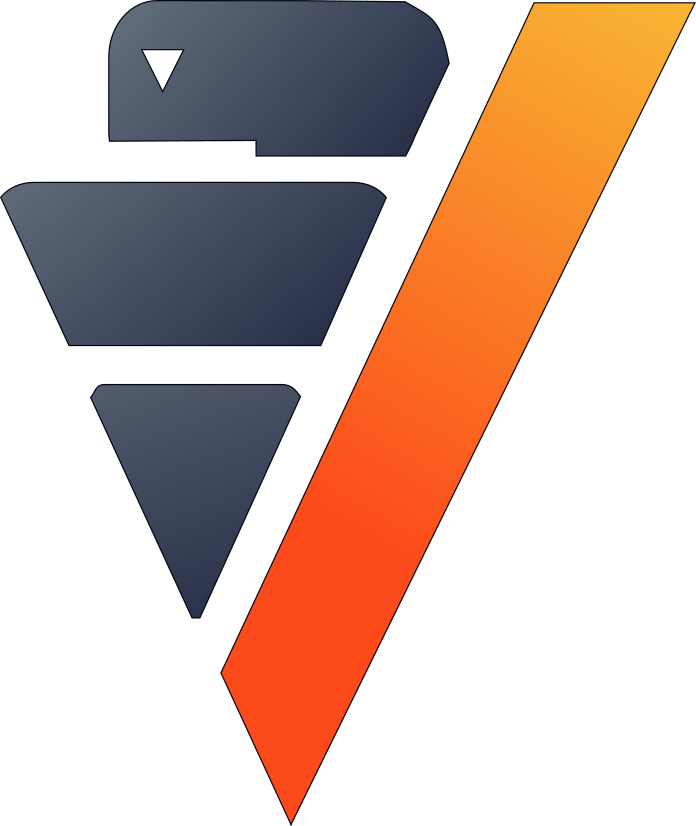

In [17]:
# join with homogene time stamps
interpolated_sm_consumption.join(sm_weather,
                                 how='left',
                                 on={"dateUTC": "dateUTC"},
                                 expr2=["temperature", "humidity"])

In case the time stamps are not homogenous between the data sets, we can still join using interpolation. In the following example, we'll have Vertica identify the closest time series to our key and merge the two datasets.

In [17]:

# <div class="alert alert-block alert-danger">
#     <b>To be fixed</b>: 
# sm_consumption.join(sm_weather,
#                     how = "left",
#                     on_interpolate = {"dateUTC": "dateUTC"},
#                     expr2 = ["temperature", "humidity"])
# </div>

## Duplicates
One of the main steps in data preparation is removing duplicates and deal with missing values (empty data).

YEAR    MONTH    DAY    DAY_OF_WEEK    AIRLINE    FLIGHT_NUMBER    TAIL_NUMBER    ORIGIN_AIRPORT    DESTINATION_AIRPORT    SCHEDULED_DEPARTURE    DEPARTURE_TIME   \\
1    2015        1      7              3         UA             1057         N36476               DEN                    LAS                   1910              2148   \\
2    2015        4     19              7         F9             1300         N209FR               ORD                    MIA                    630               621   \\
3    2015        7     16              4         OO             6498         N130SY               BOI                    LAX                   1551              1551   \\
4    2015        7     25              6         F9              124         N206FR               DEN                    DFW                    600               609   \\
5    2015       12     17              4         EV             3812         N17560               ORD                    SDF                   1040              1205   \\
     DEPARTURE_DELAY    TAXI_OUT    WHEELS_OFF    SCHEDULED_TIME    ELAPSED_TIME    AIR_TIME    DISTANCE    WHEELS_ON    TAXI_IN    SCHEDULED_ARRIVAL    ARRIVAL_TIME   \\
1                158          12          2200               118             104          85         628         2225          7                 2008            2232   \\
2                 -9          21           642               180             195         169        1197         1031          5                 1030            1036   \\
3                  0          13          1604               139             143         115         674         1659         15                 1710            1714   \\
4                  9          12           621               111             106          87         641          848          7                  851             855   \\
5                 85          18          1223                78              78          52         286         1415          8                 1258            1423   \\
     ARRIVAL_DELAY    DIVERTED    CANCELLED    CANCELLATION_REASON    AIR_SYSTEM_DELAY    SECURITY_DELAY    AIRLINE_DELAY    LATE_AIRCRAFT_DELAY    WEATHER_DELAY   \\
1              144           0            0                   None                   0                 0                0                    144                0   \\
2                6           0            0                   None                None              None             None                   None             None   \\
3                4           0            0                   None                None              None             None                   None             None   \\
4                4           0            0                   None                None              None             None                   None             None   \\
5               85           0            0                   None                   0                 0               85                      0                0   \\
                    airline_long    occurrence  
1          United Air Lines Inc.             2  
2         Frontier Airlines Inc.             2  
3          Skywest Airlines Inc.             2  
4         Frontier Airlines Inc.             2  
5    Atlantic Southeast Airlines             2  
Rows: 5 | Columns: 33
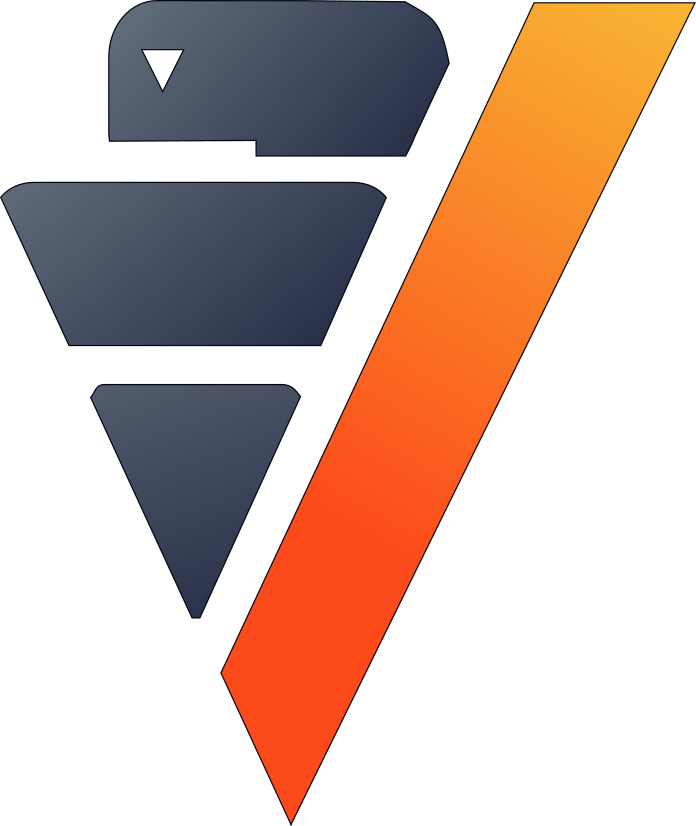

In [19]:
# Add duplicates
flights = flights.append(flights.sample(5))
# Find duplicates
flights.duplicated()

5 elements were filtered.


YEAR    MONTH    DAY    DAY_OF_WEEK    AIRLINE    FLIGHT_NUMBER    TAIL_NUMBER    ORIGIN_AIRPORT    DESTINATION_AIRPORT    SCHEDULED_DEPARTURE    DEPARTURE_TIME   \\
1      2015        1      1              4         AA                6         N398AA               OGG                    DFW                   1805              None   \\
2      2015        1      1              4         AA               12         N792AA               LAX                    JFK                   1115              1114   \\
3      2015        1      1              4         AA               17         N019AA               ATL                    MIA                    700               656   \\
4      2015        1      1              4         AA               19         N786AA               JFK                    LAX                   1100              1055   \\
5      2015        1      1              4         AA               22         N786AA               LAX                    JFK                   1515              1512   \\
6      2015        1      1              4         AA               23         N371AA               SFO                    DFW                   1050              1123   \\
7      2015        1      1              4         AA               36         N3EKAA               SAN                    DFW                    935               928   \\
8      2015        1      1              4         AA               42         N3GPAA               SEA                    ORD                    850               849   \\
9      2015        1      1              4         AA               45         N3ELAA               JFK                    LAS                   1729              1727   \\
10     2015        1      1              4         AA               48         N3JXAA               SAN                    DFW                    835               830   \\
11     2015        1      1              4         AA               55         N3JJAA               ORD                    LAS                   1820              1924   \\
12     2015        1      1              4         AA               61         N850AA               MIA                    DFW                    715               719   \\
13     2015        1      1              4         AA               63         N3ECAA               MIA                    PHX                   1950              1955   \\
14     2015        1      1              4         AA               66         N631AA               SJU                    JFK                   1151              1142   \\
15     2015        1      1              4         AA               67         N631AA               JFK                    SJU                   1605              1629   \\
16     2015        1      1              4         AA               71         N3GHAA               DFW                    SAN                   1805              1803   \\
17     2015        1      1              4         AA               74         N488AA               CLE                    DFW                   1555              1552   \\
18     2015        1      1              4         AA               79         N520AA               DFW                    SMF                   2140              2219   \\
19     2015        1      1              4         AA               80         N4XTAA               TUS                    DFW                   1655              1741   \\
20     2015        1      1              4         AA               84         N3AXAA               BOS                    JFK                    940               930   \\
21     2015        1      1              4         AA               93         N3HHAA               ORD                    SAN                   1720              1805   \\
22     2015        1      1              4         AA              102         N376AA               HNL                    DFW                   1920              2356   \\
23     2015        1      1 
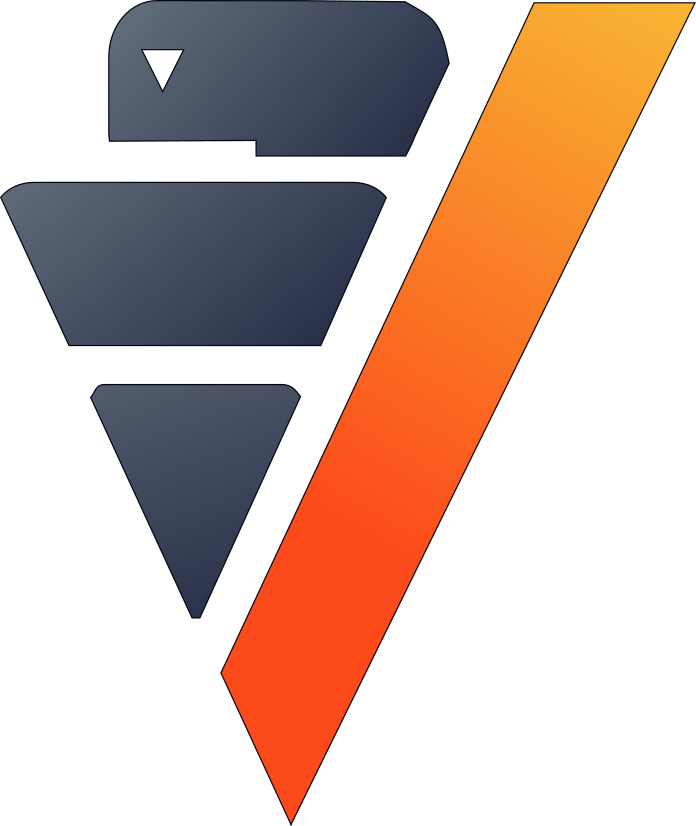

In [20]:
# Drop duplicates
flights.drop_duplicates()

## Missing Values
Dealing with missing values is crucial for some machine learning models (can't handle missing values). There are different approaches to dealing with them based on their type.

- __MCAR (Missing Completely at Random)__ : The events that lead to any particular data-item being missing occur entirely at random. For example, in IOT, we can lose sensory data in transmission.
- __MAR (Missing {Conditionally} at Random)__ : Missing data doesn't happen at random and is instead related to some of the observed data. For example, some students may have not answered to some specific questions of a test because they were absent during the relevant lesson.
- __MNAR (Missing not at Random)__ : The value of the variable that’s missing is related to the reason it’s missing. For example, if someone didn’t subscribe to a loyalty program, we can leave the cell empty.

We can examine the missing values with the `count_percent` method.

count    percent  
"pclass"         1234.0      100.0  
"survived"       1234.0      100.0  
"name"           1234.0      100.0  
"sex"            1234.0      100.0  
"sibsp"          1234.0      100.0  
"parch"          1234.0      100.0  
"ticket"         1234.0      100.0  
"fare"           1233.0     99.919  
"embarked"       1232.0     99.838  
"age"             997.0     80.794  
"home.dest"       706.0     57.212  
"boat"            439.0     35.575  
"cabin"           286.0     23.177  
"body"            118.0      9.562  
Rows: 1-14 | Columns: 3
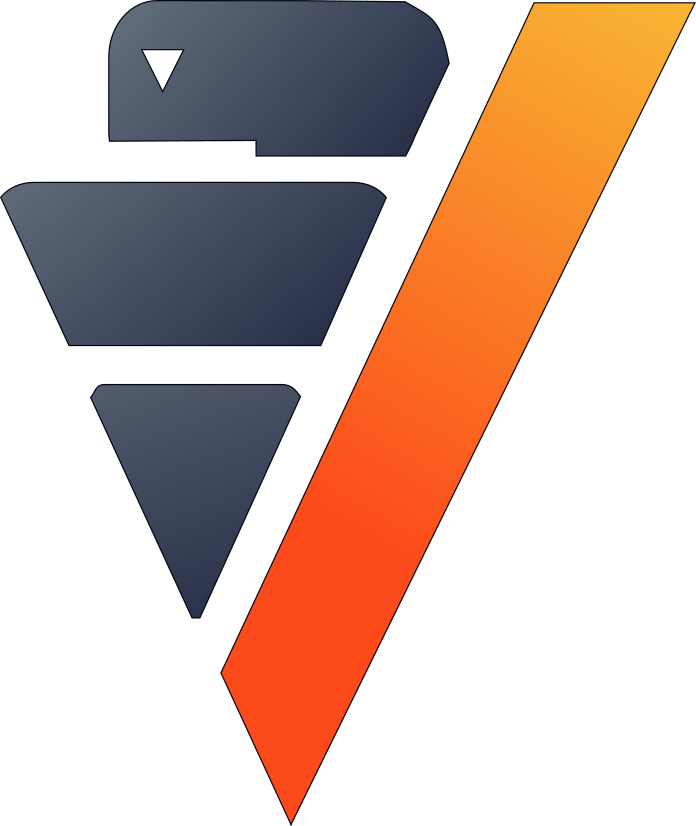

In [21]:
from verticapy.datasets import load_titanic
titanic = load_titanic()
titanic.count_percent()


The missing values for `boat` are __MNAR__; missing values simply indicate that the passengers didn't pay for a lifeboat. We can replace all the missing values with a new category 'No Lifeboat' using the `fillna` method.

795 elements were filled.


boat  
1      No Lifeboat  
2      No Lifeboat  
3      No Lifeboat  
4      No Lifeboat  
5      No Lifeboat  
6      No Lifeboat  
7      No Lifeboat  
8      No Lifeboat  
9                A  
10     No Lifeboat  
11     No Lifeboat  
12     No Lifeboat  
13     No Lifeboat  
14     No Lifeboat  
15     No Lifeboat  
16     No Lifeboat  
17     No Lifeboat  
18     No Lifeboat  
19     No Lifeboat  
20     No Lifeboat  
21     No Lifeboat  
22     No Lifeboat  
23     No Lifeboat  
24     No Lifeboat  
25     No Lifeboat  
26     No Lifeboat  
27     No Lifeboat  
28     No Lifeboat  
29     No Lifeboat  
30     No Lifeboat  
31     No Lifeboat  
32     No Lifeboat  
33     No Lifeboat  
34     No Lifeboat  
35     No Lifeboat  
36     No Lifeboat  
37     No Lifeboat  
38     No Lifeboat  
39     No Lifeboat  
40     No Lifeboat  
41     No Lifeboat  
42     No Lifeboat  
43     No Lifeboat  
44     No Lifeboat  
45     No Lifeboat  
46     No Lifeboat  
47     No Lifeboat  
48     No Lifeboat  
49     No Lifeboat  
50     No Lifeboat  
51     No Lifeboat  
52     No Lifeboat  
53     No Lifeboat  
54     No Lifeboat  
55     No Lifeboat  
56              14  
57     No Lifeboat  
58     No Lifeboat  
59     No Lifeboat  
60     No Lifeboat  
61     No Lifeboat  
62     No Lifeboat  
63     No Lifeboat  
64     No Lifeboat  
65     No Lifeboat  
66     No Lifeboat  
67     No Lifeboat  
68     No Lifeboat  
69     No Lifeboat  
70     No Lifeboat  
71     No Lifeboat  
72     No Lifeboat  
73     No Lifeboat  
74     No Lifeboat  
75     No Lifeboat  
76     No Lifeboat  
77     No Lifeboat  
78     No Lifeboat  
79     No Lifeboat  
80     No Lifeboat  
81     No Lifeboat  
82     No Lifeboat  
83     No Lifeboat  
84     No Lifeboat  
85     No Lifeboat  
86     No Lifeboat  
87     No Lifeboat  
88     No Lifeboat  
89     No Lifeboat  
90     No Lifeboat  
91     No Lifeboat  
92     No Lifeboat  
93     No Lifeboat  
94     No Lifeboat  
95     No Lifeboat  
96     No Lifeboat  
97     No Lifeboat  
98     No Lifeboat  
99     No Lifeboat  
100    No Lifeboat  
...            ...  
Rows: 1-100 of 1234 | Column: boat | Type: Varchar(100)
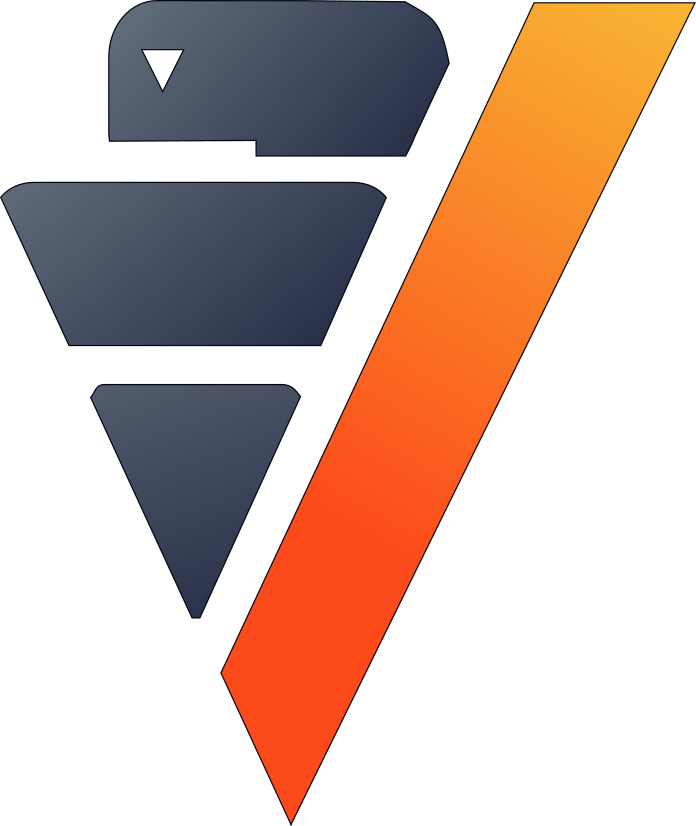

In [22]:
# fill null values with new value
titanic["boat"].fillna("No Lifeboat")
titanic["boat"]

Missing values for `age` seem to be __MCAR__, so the best way to impute them is with mathematical aggregations. Let's impute the age using the average age of passengers of the same sex and class.

237 elements were filled.


age  
1                  36.0  
2                  31.0  
3                  21.0  
4                  50.0  
5                  45.0  
6                  31.0  
7                  55.0  
8                  60.0  
9                  35.0  
10     37.2635658914729  
11                 39.0  
12     37.2635658914729  
13                 39.0  
14                 18.0  
15                 48.0  
16                 62.0  
17                 52.0  
18                 43.0  
19     37.2635658914729  
20                 40.0  
21                 23.0  
22                 18.0  
23                 39.0  
24                 40.0  
25                 30.0  
26                 35.0  
27                 24.0  
28                 48.0  
29                 18.0  
30                 54.0  
31                 33.0  
32                 33.0  
33                 43.0  
34                 56.0  
35                 30.0  
36                 17.0  
37                 22.0  
38                 22.0  
39                 39.0  
40                 19.0  
41                 23.0  
42                 31.0  
43                 37.0  
44                 33.0  
45     37.2635658914729  
46                 18.0  
47                 16.0  
48                 15.0  
49                 58.0  
50                 21.0  
51                 51.0  
52                 16.0  
53                 55.0  
54                 49.0  
55                 30.0  
56                 39.0  
57                 45.0  
58     37.2635658914729  
59                 38.0  
60                 35.0  
61                 35.0  
62                 51.0  
63                 44.0  
64                 16.0  
65                 52.0  
66                 24.0  
67                 35.0  
68                 49.0  
69                 25.0  
70                 45.0  
71                 58.0  
72                 19.0  
73     37.2635658914729  
74                 45.0  
75                 22.0  
76                 35.0  
77                 35.0  
78                 48.0  
79                 22.0  
80     37.2635658914729  
81                 30.0  
82                 60.0  
83                 23.0  
84                 28.0  
85                 24.0  
86     37.2635658914729  
87     37.2635658914729  
88                 54.0  
89                 38.0  
90                 23.0  
91                 48.0  
92                 27.0  
93                 54.0  
94                 17.0  
95                 27.0  
96                 33.0  
97                 38.0  
98                 64.0  
99                 36.0  
100                55.0  
...                 ...  
Rows: 1-100 of 1234 | Column: age | Type: Float(22)
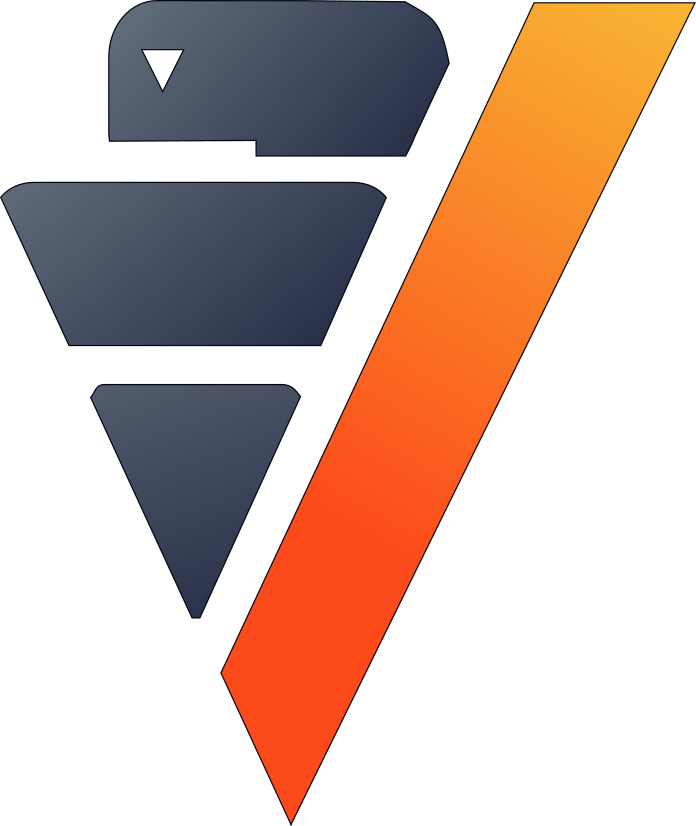

In [23]:
# fill null values with age average w.r.t class and sex
titanic["age"].fillna(method="avg",
                      by=["pclass", "sex"])
titanic["age"]

The features `embarked` and `fare` have a couple missing values. Instead of using a technique to impute them, we can just drop them with the `dropna` method.

1 element was filtered.
2 elements were filtered.


pclass    survived                                      name       sex                 age    sibsp    parch        ticket        fare              cabin   \\
1           1           1                  Young, Miss. Marie Grice    female                36.0        0        0      PC 17760    135.6333                C32   \\
2           1           1                 Wilson, Miss. Helen Alice    female                31.0        0        0         16966       134.5            E39 E41   \\
3           1           1                  Willard, Miss. Constance    female                21.0        0        0        113795       26.55               None   \\
4           1           1  Widener, Mrs. George Dunton (Eleanor ...    female                50.0        1        1        113503       211.5                C80   \\
5           1           1  Wick, Mrs. George Dennick (Mary Hitch...    female                45.0        1        1         36928    164.8667               None   \\
6           1           1                  Wick, Miss. Mary Natalie    female                31.0        0        2         36928    164.8667                 C7   \\
7           1           1     White, Mrs. John Stuart (Ella Holmes)    female                55.0        0        0      PC 17760    135.6333                C32   \\
8           1           1  Warren, Mrs. Frank Manley (Anna Sophi...    female                60.0        1        0        110813       75.25                D37   \\
9           1           1                          Ward, Miss. Anna    female                35.0        0        0      PC 17755    512.3292               None   \\
10          1           1            Thorne, Mrs. Gertrude Maybelle    female    37.2635658914729        0        0      PC 17585        79.2               None   \\
11          1           1  Thayer, Mrs. John Borland (Marian Lon...    female                39.0        1        1         17421    110.8833                C68   \\
12          1           1  Taylor, Mrs. Elmer Zebley (Juliet Cum...    female    37.2635658914729        1        0         19996        52.0               C126   \\
13          1           1    Taussig, Mrs. Emil (Tillie Mandelbaum)    female                39.0        1        1        110413       79.65                E67   \\
14          1           1                       Taussig, Miss. Ruth    female                18.0        0        2        110413       79.65                E68   \\
15          1           1  Swift, Mrs. Frederick Joel (Margaret ...    female                48.0        0        0         17466     25.9292                D17   \\
16          1           1  Stephenson, Mrs. Walter Bertram (Mart...    female                52.0        1        0         36947     78.2667                D20   \\
17          1           1  Stengel, Mrs. Charles Emil Henry (Ann...    female                43.0        1        0         11778     55.4417               C116   \\
18          1           1  Spencer, Mrs. William Augustus (Marie...    female    37.2635658914729        1        0      PC 17569    146.5208                B78   \\
19          1           1  Spedden, Mrs. Frederic Oakley (Margar...    female                40.0        1        1         16966       134.5                E34   \\
20          1           1  Snyder, Mrs. John Pillsbury (Nelle St...    female                23.0        1        0         21228     82.2667                B45   \\
21          1           1  Smith, Mrs. Lucien Philip (Mary Elois...    female                18.0        1        0         13695        60.0                C31   \\
22          1           1  Silvey, Mrs. William Baird (Alice Mun...    female                39.0        1        0         13507        55.9                E44   \\
23          1           1                 Shutes, Miss. Elizabeth W    female                40.0        0        0      PC 17582    153.4625               C125   \\
24          1          
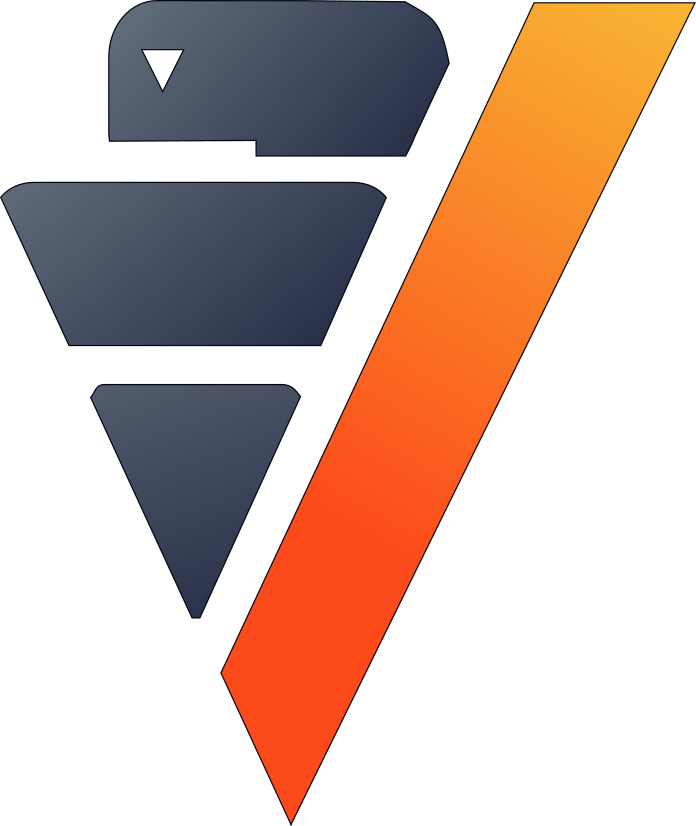

In [24]:
# titanic drop the records with null values
titanic["fare"].dropna()
titanic["embarked"].dropna()

Check [`fillna`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/fillna/) for more options.

To investigate all the transformers performed on the data, you can use `current_relation` to display the SQL query.

In [25]:
print(titanic.current_relation())

(
   SELECT
     * 
   FROM
 (
   SELECT
     "pclass",
     "survived",
     "name",
     "sex",
     COALESCE("age", AVG("age") OVER (PARTITION BY "pclass", "sex")) AS "age",
     "sibsp",
     "parch",
     "ticket",
     "fare",
     "cabin",
     "embarked",
     COALESCE("boat", 'No Lifeboat') AS "boat",
     "body",
     "home.dest" 
   FROM
 "public"."titanic") 
VERTICAPY_SUBTABLE WHERE ("fare" IS NOT NULL) AND ("embarked" IS NOT NULL)) 
VERTICAPY_SUBTABLE


## Outliers

Detecting outliers in the data set is very important, they can be an error in data acquisition or they refer to important information such as machine failure, or system fraud,...

Some ML models are so sensitive to outliers. In fact, they can destroy the final predictions because of how much bias they add to the data.

Outliers consist of three main types:

- __Global Outliers__ : Values far outside the entirety of their source dataset
- __Contextual Outliers__ : Values deviate significantly from the rest of the data points in the same context
- __Collective Outliers__ : Values that aren't global or contextual outliers, but as a collection deviate significantly from the entire dataset

Global outliers are often the most critical type and can add a significant amount of bias into the data. Fortunately, we can easily identify these outliers by computing the Z-Score.


Let's look at some examples using the [_Heart Disease_](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) dataset. This dataset contains information on patients who are likely to have heart-related complications.

In [26]:
try:
    # Load data to db
    vp.read_csv("data/heart.csv",
                table_name='heart_data',
                schema='public')
    # Read data
    heart_data = vp.vDataFrame('public.heart_data')
except:
    # Read data
    heart_data = vp.vDataFrame('public.heart_data')

Let's focus on a patient's maximum heart rate _thalach_ and the cholesterol _chol_ to identify some outliers.

<AxesSubplot:xlabel='"thalach"', ylabel='"chol"'>

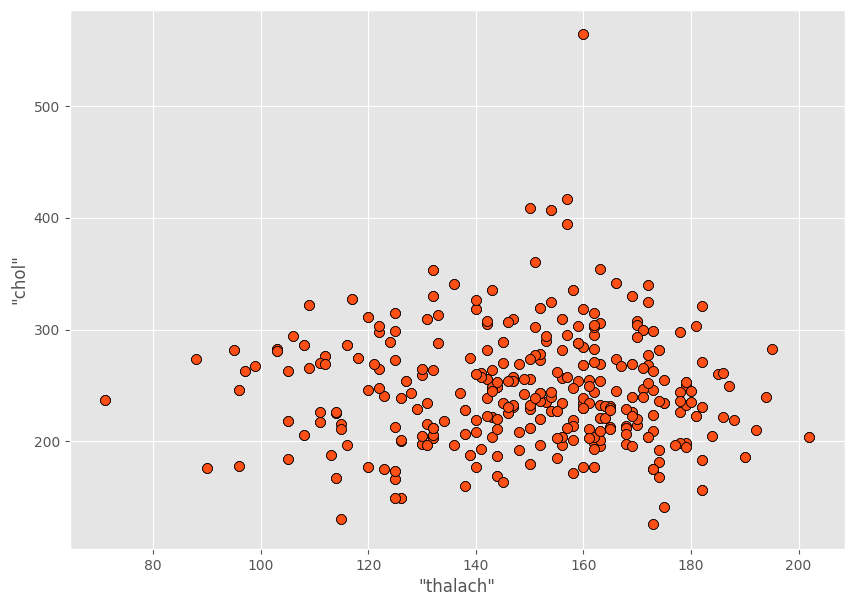

In [27]:
# set the axis
fig, ax = plt.subplots(figsize=(10, 7))
heart_data.scatter(["thalach", "chol"],
                   ax=ax)

We are observing some outliers with high cholesterol and low maximum heart rate. We will use z-score to highlight these samples using [`outliers`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/outliers/) function. 

_You can also compute z-score using mathematical aggregation and function_

age    sex    cp    trestbps    chol    fbs    restecg    thalach    exang    oldpeak    slope    ca    thal    target    global_outliers  
1       29      1     1         130     204      0          0        202        0        0.0        2     0       2         1                  0  
2       29      1     1         130     204      0          0        202        0        0.0        2     0       2         1                  0  
3       29      1     1         130     204      0          0        202        0        0.0        2     0       2         1                  0  
4       29      1     1         130     204      0          0        202        0        0.0        2     0       2         1                  0  
5       34      0     1         118     210      0          1        192        0        0.7        2     0       2         1                  0  
6       34      0     1         118     210      0          1        192        0        0.7        2     0       2         1                  0  
7       34      0     1         118     210      0          1        192        0        0.7        2     0       2         1                  0  
8       34      1     3         118     182      0          0        174        0        0.0        2     0       2         1                  0  
9       34      1     3         118     182      0          0        174        0        0.0        2     0       2         1                  0  
10      34      1     3         118     182      0          0        174        0        0.0        2     0       2         1                  0  
11      35      0     0         138     183      0          1        182        0        1.4        2     0       2         1                  0  
12      35      0     0         138     183      0          1        182        0        1.4        2     0       2         1                  0  
13      35      0     0         138     183      0          1        182        0        1.4        2     0       2         1                  0  
14      35      0     0         138     183      0          1        182        0        1.4        2     0       2         1                  0  
15      35      1     0         120     198      0          1        130        1        1.6        1     0       3         0                  0  
16      35      1     0         120     198      0          1        130        1        1.6        1     0       3         0                  0  
17      35      1     0         120     198      0          1        130        1        1.6        1     0       3         0                  0  
18      35      1     0         120     198      0          1        130        1        1.6        1     0       3         0                  0  
19      35      1     0         126     282      0          0        156        1        0.0        2     0       3         0                  0  
20      35      1     0         126     282      0          0        156        1        0.0        2     0       3         0                  0  
21      35      1     0         126     282      0          0        156        1        0.0        2     0       3         0                  0  
22      35      1     1         122     192      0          1        174        0        0.0        2     0       2         1                  0  
23      35      1     1         122     192      0          1        174        0        0.0        2     0       2         1                  0  
24      35      1     1         122     192      0          1        174        0        0.0        2     0       2         1                  0  
25      35      1     1         122     192      0          1        174        0        0.0        2     0       2         1                  0  
26      37      0     2         120     215      0          1        170        0        0.0        2     0       2         1                  0  
27      37      0     2         120   
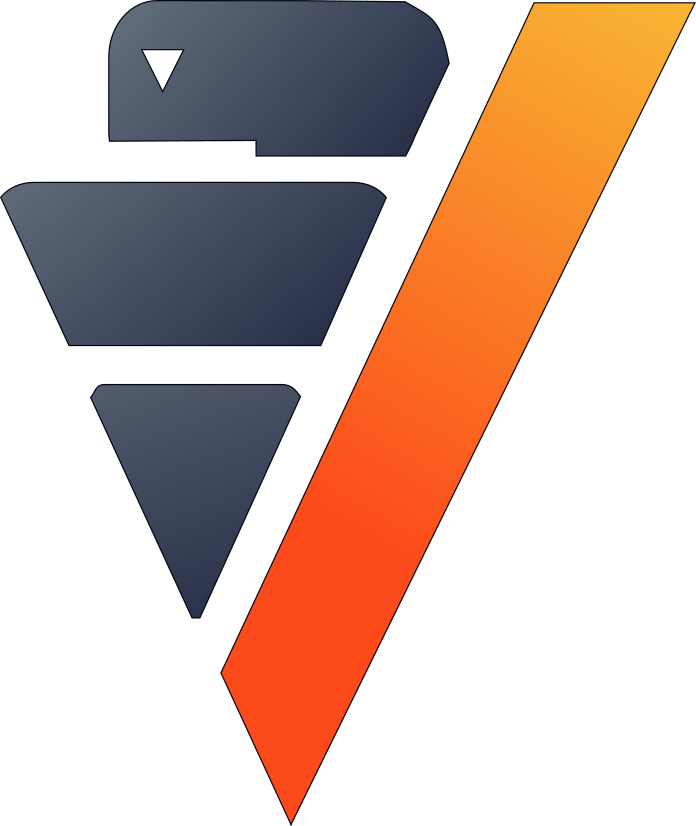

In [28]:
# Detecting outliers
heart_data.outliers(columns=["thalach", "chol"],
                    name="global_outliers",
                    threshold=3.0,
                    robust=False)

<AxesSubplot:xlabel='"thalach"', ylabel='"chol"'>

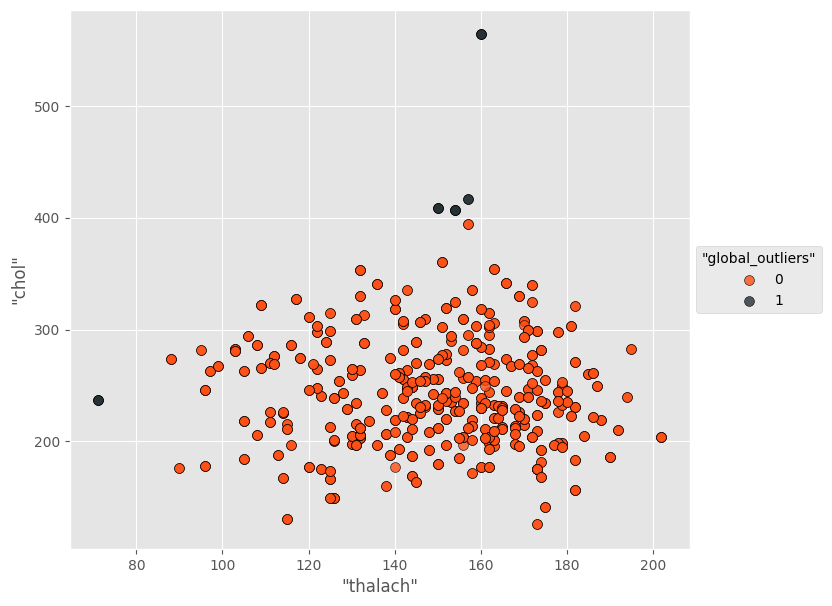

In [29]:
# set the axis
fig, ax = plt.subplots(figsize=(10, 7))
heart_data.scatter(["thalach", "chol"],
                   catcol="global_outliers",
                   ax=ax)

There more advanced techniques for outliers/anomalies detection, such using clustering ML models.

[DBSCAN](https://www.vertica.com/python/documentation-0.5.0/learn/DBSCAN/index.php), [Local Outlier Factor](https://www.vertica.com/python/documentation-0.5.0/learn/LocalOutlierFactor/index.php), and [Isolation Forest](https://www.vertica.com/python/documentation_last/learn/IsolationForest/index.php).
<div class="alert alert-block alert-warning">
<b>Warning:</b> DBSCAN and Local Outlier Factor are computationally expensive</div>

<AxesSubplot:xlabel='"thalach"', ylabel='"chol"'>

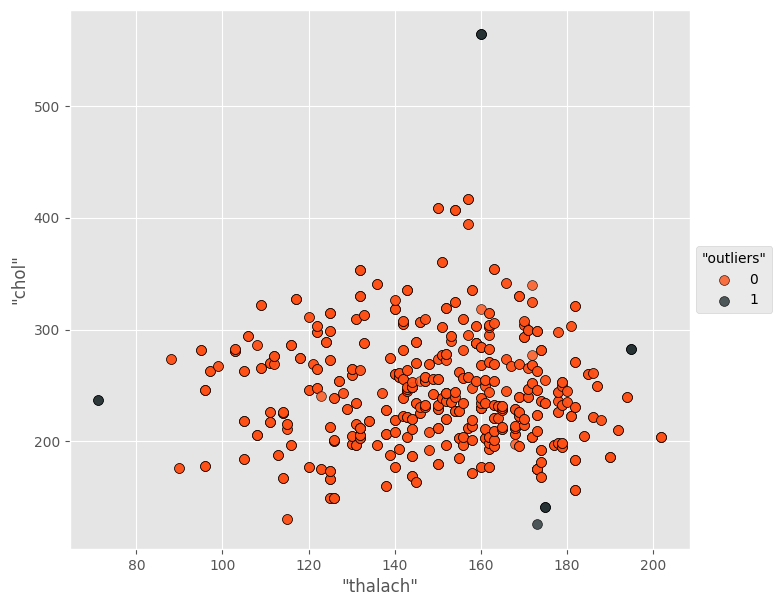

In [30]:
from verticapy.learn.neighbors import LocalOutlierFactor
fig, ax = plt.subplots(figsize=(10, 7))
# initiate the model
lof_model = LocalOutlierFactor(name="public.LOF_heart")
# fit the model
lof_model.fit(heart_data,
              ["thalach", "chol"])
# predict
lof_heart = lof_model.predict()
lof_heart["outliers"] = "(CASE WHEN lof_score > 1.8 THEN 1 ELSE 0 END)"
lof_heart.scatter(["thalach", "chol"],
                  catcol="outliers",
                  ax=ax)

## Encoding 

Usually, in a dataset, there are many types of variables: numerical, booleans, timestamps, and categorical. Some algorithms can not process non-numerical features, so we need to convert those features to numerical ones. The encoding techniques allow us to do so.

There are many encoding techniques:

- __User-Defined Encoding__ : The most flexible encoding. The user can choose how to encode the different categories.
- __Label Encoding__: Each category is converted to an integer using a bijection to [0;n-1] where n is the feature number of unique values.
- __One-hot Encoding__ : This technique creates dummies (values in {0,1}) of each category. The categories are then separated into n features.
- __Mean Encoding__ : This technique uses the frequencies of each category for a specific response column.
- [__Discretization__](https://www.vertica.com/python/documentation_last/vdataframe/vcolumn-methods/discretize/) : This technique uses various mathematical technique to encode continuous features into categories.

For more details please check this [link](https://www.vertica.com/python/workshop/data_prep/encoding/)

sex  
1        0  
2        1  
3        0  
4        1  
5        1  
6        1  
7        1  
8        1  
9        1  
10       1  
11       1  
12       1  
13       1  
14       1  
15       1  
16       1  
17       1  
18       1  
19       1  
20       1  
21       1  
22       1  
23       1  
24       1  
25       1  
26       1  
27       1  
28       1  
29       1  
30       1  
31       1  
32       1  
33       1  
34       1  
35       0  
36       1  
37       1  
38       1  
39       1  
40       1  
41       1  
42       1  
43       1  
44       1  
45       1  
46       1  
47       1  
48       1  
49       1  
50       1  
51       1  
52       1  
53       1  
54       1  
55       1  
56       1  
57       0  
58       1  
59       1  
60       1  
61       1  
62       1  
63       1  
64       1  
65       1  
66       1  
67       1  
68       1  
69       1  
70       1  
71       1  
72       1  
73       1  
74       1  
75       1  
76       1  
77       1  
78       1  
79       1  
80       1  
81       1  
82       1  
83       1  
84       1  
85       1  
86       1  
87       1  
88       1  
89       1  
90       1  
91       1  
92       1  
93       1  
94       1  
95       1  
96       1  
97       1  
98       1  
99       1  
100      1  
...    ...  
Rows: 1-100 of 1231 | Column: sex | Type: Integer
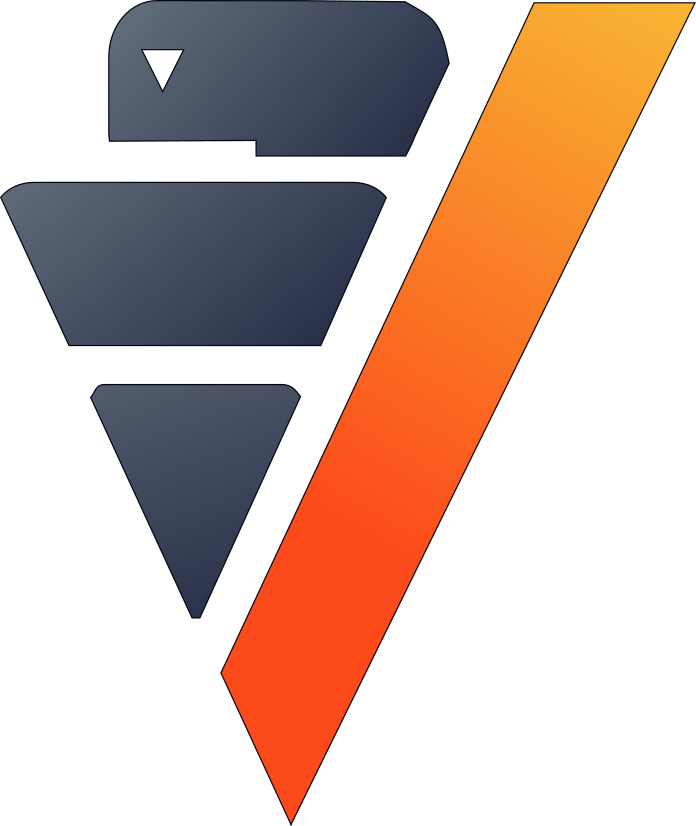

In [31]:
# label encoding for sex column
titanic["sex"].label_encode()
titanic["sex"]

embarked    embarked_C    embarked_Q  
1             S             0             0  
2             S             0             0  
3             S             0             0  
4             S             0             0  
5             C             1             0  
6             C             1             0  
7             S             0             0  
8             C             1             0  
9             C             1             0  
10            C             1             0  
11            S             0             0  
12            S             0             0  
13            S             0             0  
14            C             1             0  
15            C             1             0  
16            S             0             0  
17            S             0             0  
18            S             0             0  
19            S             0             0  
20            S             0             0  
21            S             0             0  
22            S             0             0  
23            S             0             0  
24            S             0             0  
25            C             1             0  
26            S             0             0  
27            S             0             0  
28            C             1             0  
29            S             0             0  
30            S             0             0  
31            C             1             0  
32            S             0             0  
33            C             1             0  
34            C             1             0  
35            C             1             0  
36            S             0             0  
37            C             1             0  
38            S             0             0  
39            S             0             0  
40            S             0             0  
41            S             0             0  
42            S             0             0  
43            S             0             0  
44            C             1             0  
45            C             1             0  
46            S             0             0  
47            C             1             0  
48            S             0             0  
49            S             0             0  
50            S             0             0  
51            S             0             0  
52            S             0             0  
53            S             0             0  
54            S             0             0  
55            S             0             0  
56            C             1             0  
57            C             1             0  
58            S             0             0  
59            S             0             0  
60            C             1             0  
61            C             1             0  
62            S             0             0  
63            S             0             0  
64            C             1             0  
65            S             0             0  
66            S             0             0  
67            S             0             0  
68            S             0             0  
69            C             1             0  
70            S             0             0  
71            C             1             0  
72            S             0             0  
73            Q             0             1  
74            S             0             0  
75            S             0             0  
76            C             1             0  
77            C             1             0  
78            S             0             0  
79            C             1             0  
80            C             1             0  
81            S             0             0  
82            S             0             0  
83            S             0             0  
84            S             0             0  
85            C             1             0  
86            S             0             0  
87   
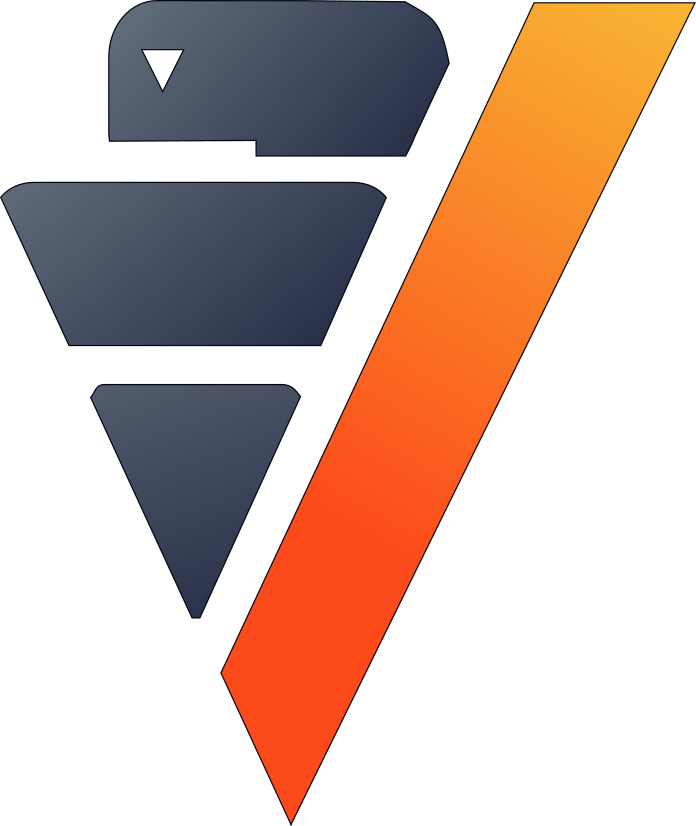

In [32]:
# one hot encoding for embarked columns
titanic["embarked"].one_hot_encode()
titanic.select(["embarked", "embarked_C", "embarked_Q"])

age  
1      [30;40]  
2      [30;40]  
3      [20;30]  
4       [0;10]  
5      [20;30]  
6       [0;10]  
7      [20;30]  
8      [10;20]  
9      [40;50]  
10     [10;20]  
11     [30;40]  
12     [20;30]  
13     [20;30]  
14     [20;30]  
15     [30;40]  
16     [20;30]  
17     [20;30]  
18     [30;40]  
19      [0;10]  
20     [20;30]  
21     [30;40]  
22     [10;20]  
23     [20;30]  
24     [20;30]  
25     [20;30]  
26      [0;10]  
27     [20;30]  
28     [20;30]  
29     [20;30]  
30     [20;30]  
31     [20;30]  
32     [30;40]  
33     [20;30]  
34     [20;30]  
35     [20;30]  
36     [20;30]  
37     [20;30]  
38     [20;30]  
39     [20;30]  
40     [30;40]  
41     [20;30]  
42     [30;40]  
43     [30;40]  
44      [0;10]  
45     [20;30]  
46     [20;30]  
47     [20;30]  
48     [20;30]  
49     [20;30]  
50     [20;30]  
51     [20;30]  
52     [20;30]  
53     [20;30]  
54     [20;30]  
55     [10;20]  
56      [0;10]  
57     [20;30]  
58     [40;50]  
59     [30;40]  
60     [20;30]  
61     [30;40]  
62     [20;30]  
63     [20;30]  
64      [0;10]  
65     [20;30]  
66      [0;10]  
67     [20;30]  
68     [20;30]  
69     [20;30]  
70     [40;50]  
71     [10;20]  
72     [20;30]  
73     [10;20]  
74     [20;30]  
75     [20;30]  
76     [20;30]  
77     [20;30]  
78     [20;30]  
79     [40;50]  
80     [20;30]  
81     [30;40]  
82     [20;30]  
83     [20;30]  
84     [20;30]  
85     [20;30]  
86     [20;30]  
87     [20;30]  
88     [10;20]  
89     [50;60]  
90     [30;40]  
91     [20;30]  
92     [20;30]  
93     [20;30]  
94     [20;30]  
95     [20;30]  
96     [20;30]  
97     [10;20]  
98     [30;40]  
99     [40;50]  
100    [20;30]  
...        ...  
Rows: 1-100 of 1231 | Column: age | Type: Varchar(47)
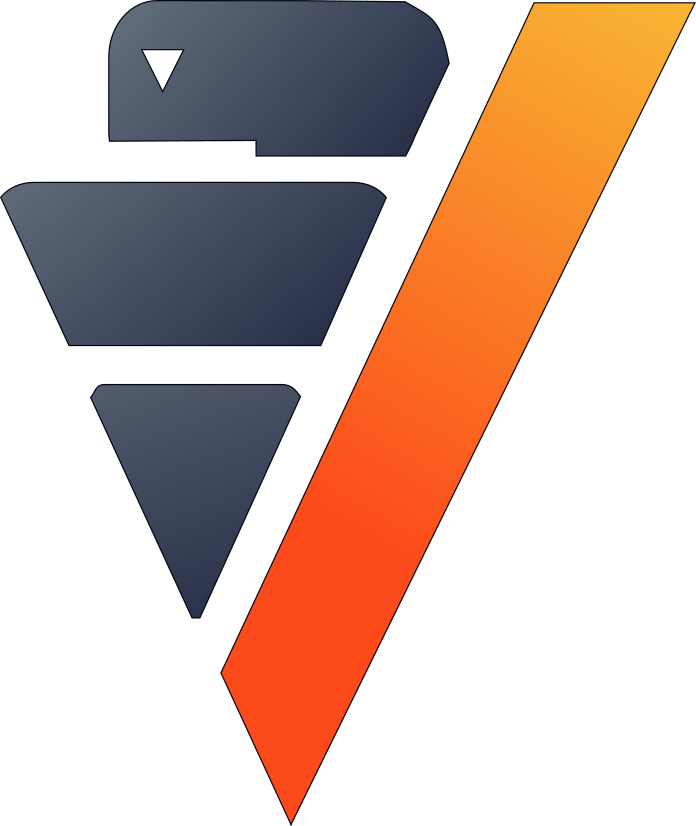

<AxesSubplot:xlabel='"age"', ylabel='Density'>

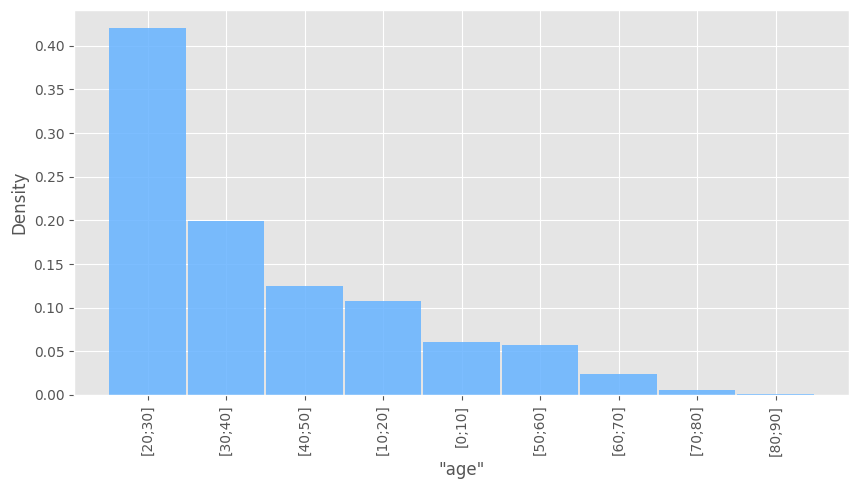

In [33]:
# customize the size of the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Discretizing using the same bar width
titanic["age"].discretize(method="same_width", h=10)
display(titanic["age"])
titanic["age"].hist(method='density',
                    max_cardinality=20,
                    color=COLOR,
                    ax=ax)

The mean encoding was successfully done.


home.dest  
1                    1.0  
2                    0.0  
3                    0.0  
4                    0.0  
5                    0.0  
6                    0.0  
7                    0.0  
8                    0.0  
9                    1.0  
10                   0.0  
11                   0.0  
12                   0.0  
13                   0.0  
14                   0.0  
15                   0.0  
16                   0.0  
17                   0.5  
18                   0.5  
19                   0.5  
20                   0.5  
21                  0.75  
22                  0.75  
23                  0.75  
24                  0.75  
25                   1.0  
26                   1.0  
27     0.666666666666667  
28     0.666666666666667  
29     0.666666666666667  
30     0.666666666666667  
31     0.666666666666667  
32     0.666666666666667  
33                   1.0  
34                   1.0  
35                   1.0  
36                   1.0  
37                   0.0  
38     0.666666666666667  
39     0.666666666666667  
40     0.666666666666667  
41                   0.0  
42                   1.0  
43                   0.0  
44                   0.0  
45                   0.0  
46                   0.0  
47                   0.0  
48                   0.5  
49                   0.5  
50                   1.0  
51                   0.0  
52     0.666666666666667  
53     0.666666666666667  
54     0.666666666666667  
55                   0.0  
56                   0.5  
57                   0.5  
58                   0.0  
59                   0.0  
60                   0.0  
61                   1.0  
62                   0.5  
63                   0.5  
64                   0.5  
65                   0.5  
66                   0.5  
67                   0.5  
68                   1.0  
69                   0.0  
70                   1.0  
71                   0.0  
72                   0.0  
73                   0.0  
74                   0.0  
75                   0.0  
76                   1.0  
77                   1.0  
78                   1.0  
79                   1.0  
80                   0.0  
81                   0.5  
82                   0.5  
83                   0.0  
84                   1.0  
85                  0.75  
86                  0.75  
87                  0.75  
88                  0.75  
89                   0.5  
90                   0.5  
91                   0.0  
92                   0.0  
93                   0.0  
94                   0.0  
95                   0.0  
96                   0.0  
97                   1.0  
98                   0.0  
99                   0.0  
100                  0.5  
...                  ...  
Rows: 1-100 of 1231 | Column: home.dest | Type: Float(22)
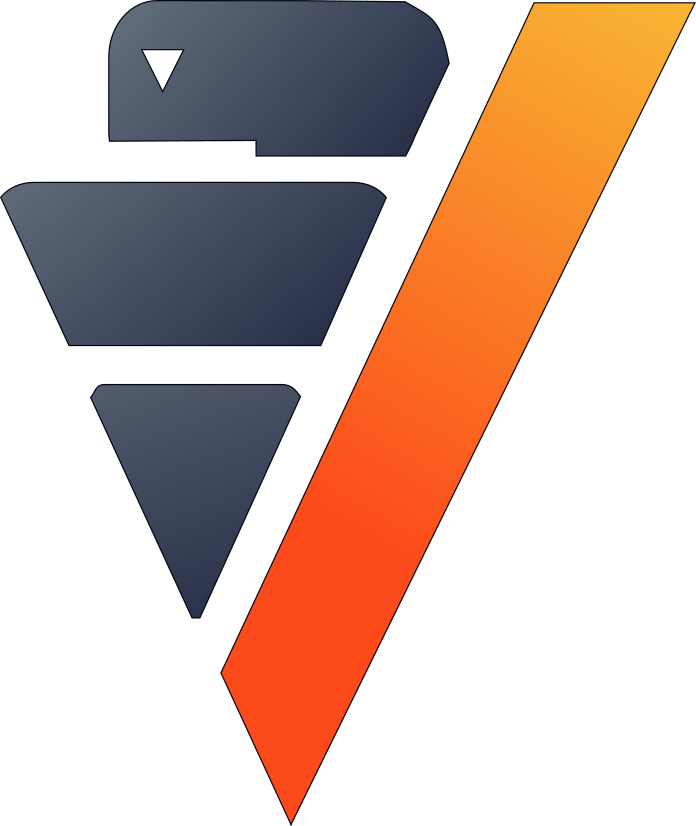

In [34]:
# mean encoding using survived as target
titanic["home.dest"].mean_encode("survived")
titanic["home.dest"]

## Decomposition

Decomposition is the process of using an orthogonal transformation to convert a set of observations of possibly-correlated variables (with numerical values) into a set of values of linearly-uncorrelated variables called principal components.

Since some algorithms are sensitive to correlated predictors, it can be a good idea to use the [PCA](https://www.vertica.com/python/documentation_last/learn/PCA/index.php) (Principal Component Analysis: Decomposition Technique) before applying the algorithm. Since some algorithms are also sensitive to the number of predictors, we'll have to be picky with which variables we include.

### PCA : Principal Component Analysis

SepalLengthCm    SepalWidthCm    PetalLengthCm    PetalWidthCm            Species  
1                4.3             3.0              1.1             0.1        Iris-setosa  
2                4.4             2.9              1.4             0.2        Iris-setosa  
3                4.4             3.0              1.3             0.2        Iris-setosa  
4                4.4             3.2              1.3             0.2        Iris-setosa  
5                4.5             2.3              1.3             0.3        Iris-setosa  
6                4.6             3.1              1.5             0.2        Iris-setosa  
7                4.6             3.2              1.4             0.2        Iris-setosa  
8                4.6             3.4              1.4             0.3        Iris-setosa  
9                4.6             3.6              1.0             0.2        Iris-setosa  
10               4.7             3.2              1.3             0.2        Iris-setosa  
11               4.7             3.2              1.6             0.2        Iris-setosa  
12               4.8             3.0              1.4             0.1        Iris-setosa  
13               4.8             3.0              1.4             0.3        Iris-setosa  
14               4.8             3.1              1.6             0.2        Iris-setosa  
15               4.8             3.4              1.6             0.2        Iris-setosa  
16               4.8             3.4              1.9             0.2        Iris-setosa  
17               4.9             2.4              3.3             1.0    Iris-versicolor  
18               4.9             2.5              4.5             1.7     Iris-virginica  
19               4.9             3.0              1.4             0.2        Iris-setosa  
20               4.9             3.1              1.5             0.1        Iris-setosa  
21               4.9             3.1              1.5             0.1        Iris-setosa  
22               4.9             3.1              1.5             0.1        Iris-setosa  
23               5.0             2.0              3.5             1.0    Iris-versicolor  
24               5.0             2.3              3.3             1.0    Iris-versicolor  
25               5.0             3.0              1.6             0.2        Iris-setosa  
26               5.0             3.2              1.2             0.2        Iris-setosa  
27               5.0             3.3              1.4             0.2        Iris-setosa  
28               5.0             3.4              1.5             0.2        Iris-setosa  
29               5.0             3.4              1.6             0.4        Iris-setosa  
30               5.0             3.5              1.3             0.3        Iris-setosa  
31               5.0             3.5              1.6             0.6        Iris-setosa  
32               5.0             3.6              1.4             0.2        Iris-setosa  
33               5.1             2.5              3.0             1.1    Iris-versicolor  
34               5.1             3.3              1.7             0.5        Iris-setosa  
35               5.1             3.4              1.5             0.2        Iris-setosa  
36               5.1             3.5              1.4             0.2        Iris-setosa  
37               5.1             3.5              1.4             0.3        Iris-setosa  
38               5.1             3.7              1.5             0.4        Iris-setosa  
39               5.1             3.8              1.5             0.3        Iris-setosa  
40               5.1             3.8              1.6             0.2        Iris-setosa  
41               5.1             3.8              1.9             0.4        Iris-setosa  
42               5.2             2.7              3.9             1.4    Iris-versicolor  
43               5.2             3.4              1.4             0.2        Iris-setosa  
44 
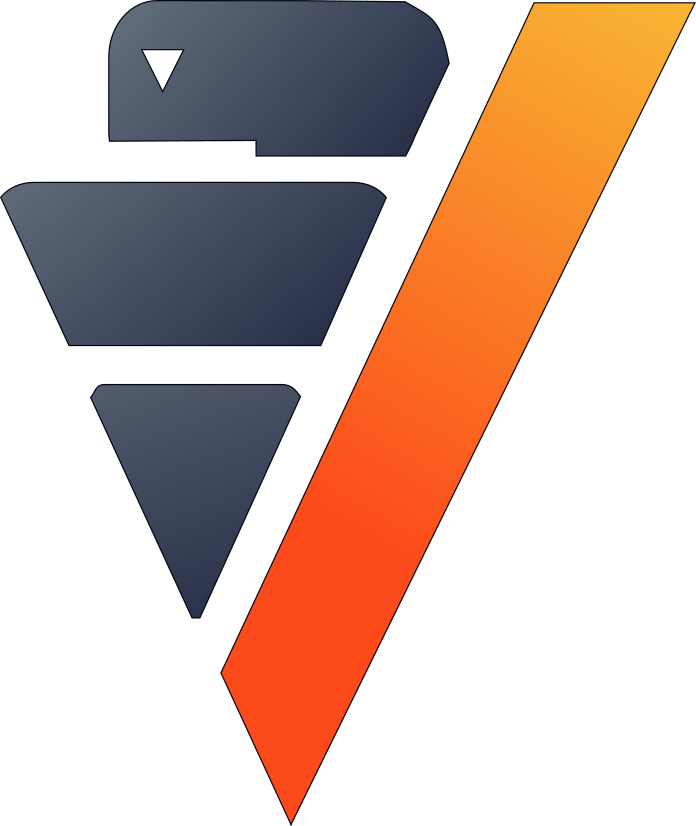

In [35]:
from verticapy.datasets import load_iris
vdf = load_iris()
display(vdf)

"SepalLengthCm"        "SepalWidthCm"       "PetalLengthCm"        "PetalWidthCm"  
"SepalLengthCm"                     1.0    -0.109369249950656     0.871754157304886     0.817953633369181  
"SepalWidthCm"       -0.109369249950656                   1.0    -0.420516096401169    -0.356544089613812  
"PetalLengthCm"       0.871754157304886    -0.420516096401169                   1.0     0.962757097050968  
"PetalWidthCm"        0.817953633369181    -0.356544089613812     0.962757097050968                   1.0  
Rows: 1-4 | Columns: 5
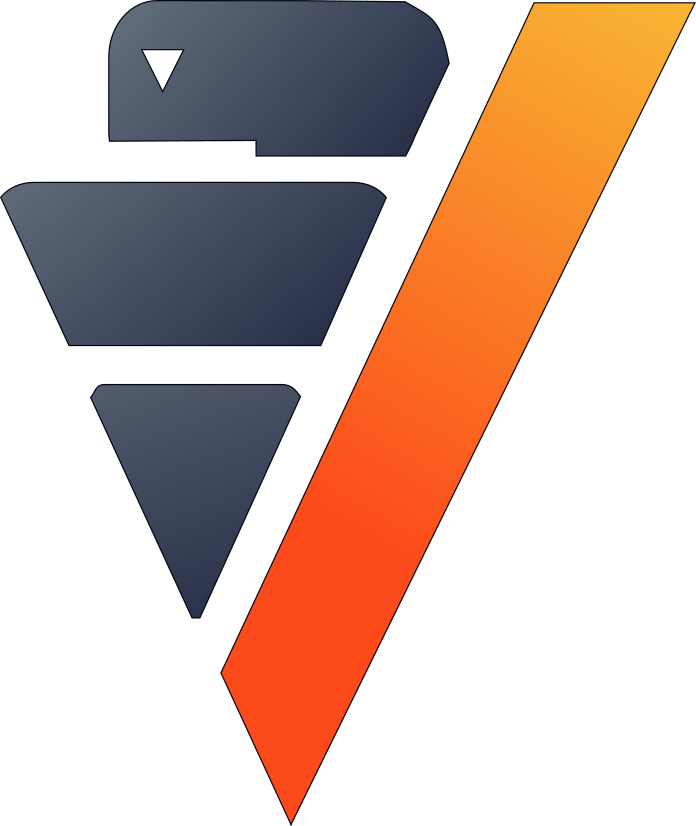

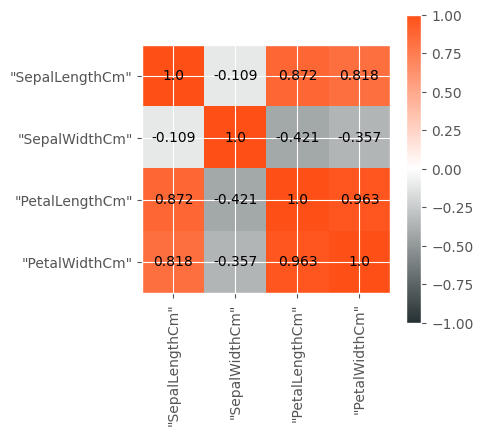

In [36]:
# Correlation matrix
vdf.corr()

We have 3 correlated columns, we can apply [PCA](https://www.vertica.com/python/documentation_last/learn/PCA/index.php). The PCA is applied only on numerical data (quantitative data)

In [37]:
from verticapy.learn.decomposition import PCA
pca_model = PCA("pca_iris")
pca_model.fit("iris", ["PetalLengthCm",
                       "SepalWidthCm",
                       "SepalLengthCm",
                       "PetalWidthCm"])



columns
index|    name     |  mean  |   sd   
-----+-------------+--------+--------
  1  |petallengthcm| 3.75867| 1.76442
  2  |sepalwidthcm | 3.05400| 0.43359
  3  |sepallengthcm| 5.84333| 0.82807
  4  |petalwidthcm | 1.19867| 0.76316


singular_values
index| value  |explained_variance|accumulated_explained_variance
-----+--------+------------------+------------------------------
  1  | 2.05544|      0.92462     |            0.92462           
  2  | 0.49218|      0.05302     |            0.97763           
  3  | 0.28022|      0.01719     |            0.99482           
  4  | 0.15389|      0.00518     |            1.00000           


principal_components
index|  PC1   |  PC2   |  PC3   |  PC4   
-----+--------+--------+--------+--------
  1  | 0.85657|-0.17577| 0.07252|-0.47972
  2  |-0.08227| 0.72971| 0.59642|-0.32409
  3  | 0.36159| 0.65654|-0.58100| 0.31725
  4  | 0.35884|-0.07471| 0.54906| 0.75112


counters
   counter_name   |counter_value
------------------+-------------
ac

value     explained_variance    accumulated_explained_variance  
1           2.05544174529956      0.924616207174268                 0.924616207174268  
2          0.492182457659265     0.0530155678505349                 0.977631775024803  
3           0.28022117709794     0.0171851395250069                  0.99481691454981  
4          0.153892907978251    0.00518308545019004                               1.0  
Rows: 1-4 | Columns: 4
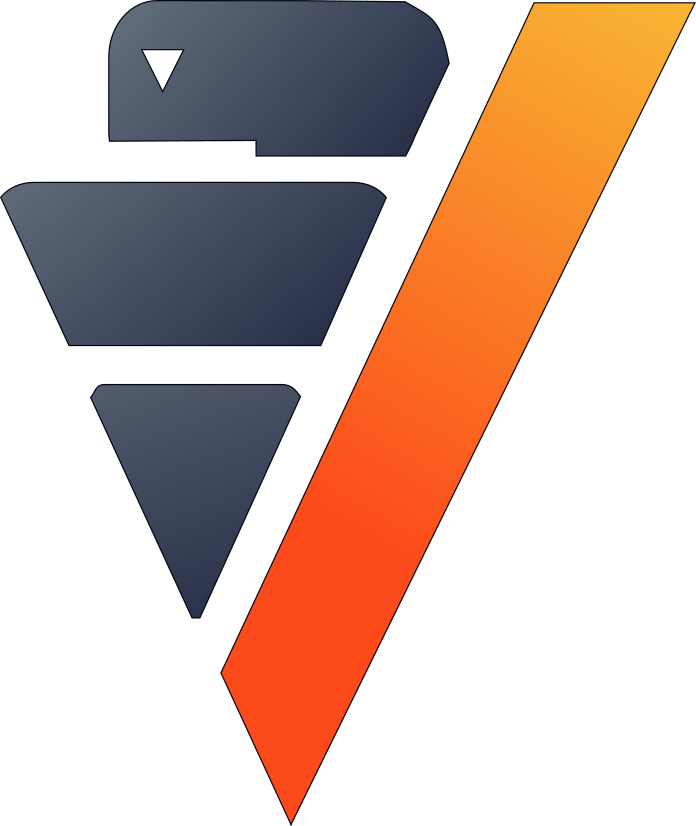

In [38]:
pca_model.explained_variance_

Species                  col1                  col2  
1          Iris-setosa     -1.64125667696593     -3.16666322697178  
2          Iris-setosa      -1.4030112816084     -3.06771988647505  
3          Iris-setosa     -1.44739713833577     -3.06040263767098  
4          Iris-setosa     -1.46385091631421     -2.91446016340568  
5          Iris-setosa     -1.26826731225734      -3.5962486849559  
6          Iris-setosa     -1.21199167079059     -2.89127690456689  
7          Iris-setosa     -1.25637752751796     -2.88395965576283  
8          Iris-setosa     -1.23694691287158     -2.74548782851103  
9          Iris-setosa     -1.43392095442743     -2.85469066054656  
10         Iris-setosa     -1.20687928472705     -2.96719038443428  
11         Iris-setosa     -1.09840238151262     -2.77022841944853  
12         Iris-setosa     -1.10449372110623     -3.05758496370035  
13         Iris-setosa     -1.03272493585659     -3.07252625772736  
14         Iris-setosa     -1.00451828199434     -2.86077639692404  
15         Iris-setosa     -1.02919894896201     -2.64186268552609  
16         Iris-setosa    -0.920722045747573     -2.44490072054034  
17     Iris-versicolor    0.0405047440062972     -2.33279917171757  
18      Iris-virginica     0.717376216248567     -1.52427460373645  
19         Iris-setosa    -0.982952117952359     -3.08263235105672  
20         Iris-setosa    -0.990904431828257     -2.93653647858199  
21         Iris-setosa    -0.990904431828257     -2.93653647858199  
22         Iris-setosa    -0.990904431828257     -2.93653647858199  
23     Iris-versicolor     0.231387445968525     -2.51095288393387  
24     Iris-versicolor     0.134388843524571     -2.42334714919308  
25         Iris-setosa    -0.824976971947017     -2.96890111474242  
26         Iris-setosa     -0.98606662087804     -3.08557459379146  
27         Iris-setosa    -0.921975574390971     -2.88129538000164  
28         Iris-setosa    -0.894043495642047     -2.74267015454041  
29         Iris-setosa    -0.786115742654259     -2.69195746023883  
30         Iris-setosa    -0.938703927482737     -2.80847754107843  
31         Iris-setosa    -0.722573846393837     -2.63392751713319  
32         Iris-setosa    -0.946656241358635     -2.66238166860369  
33     Iris-versicolor     0.130999765485567      -2.4994140272699  
34         Iris-setosa    -0.620188282773019     -2.72432209639927  
35         Iris-setosa    -0.808386285112995     -2.76024689488327  
36         Iris-setosa    -0.852772141840361     -2.75292964607921  
37         Iris-setosa     -0.81688774921554     -2.76040029309271  
38         Iris-setosa    -0.761298166831016     -2.55627447751233  
39         Iris-setosa    -0.805409448445059     -2.47583259336618  
40         Iris-setosa    -0.805134873331736     -2.40270795802409  
41         Iris-setosa    -0.624889184867658     -2.22068728706535  
42     Iris-versicolor     0.633287085553947     -1.80257433943073  
43         Iris-setosa    -0.758888042322087     -2.84347762355472  
44         Iris-setosa    -0.730955963573163     -2.70485239809349  
45         Iris-setosa    -0.816201690133313     -2.25955432828409  
46         Iris-setosa    -0.661752531022554     -2.57648666417105  
47     Iris-versicolor      1.03275903869808     -1.23236082576052  
48         Iris-setosa    -0.479645868276193     -2.82791840993888  
49         Iris-setosa    -0.479096718049546      -2.6816691392547  
50         Iris-setosa      -0.5760953204935     -2.59406340451392  
51         Iris-setosa     -0.59309824869859     -2.59437020093279  
52         Iris-setosa     -0.44846237774601     -2.33175424761846  
53     Iris-versicolor     0.923440848211315     -2.07406487364784  
54     Iris-versicolor     0.699083878133194     -2.17564366046043  
55     Iris-versicolor      0.77112723849616     -2.11746031914535  
56     Iris-versicolor     0.906987070232872     -1.92812239938254  
57     Iris-versicolor      1.00751165957141     -1.58506456192205  
58         Ir
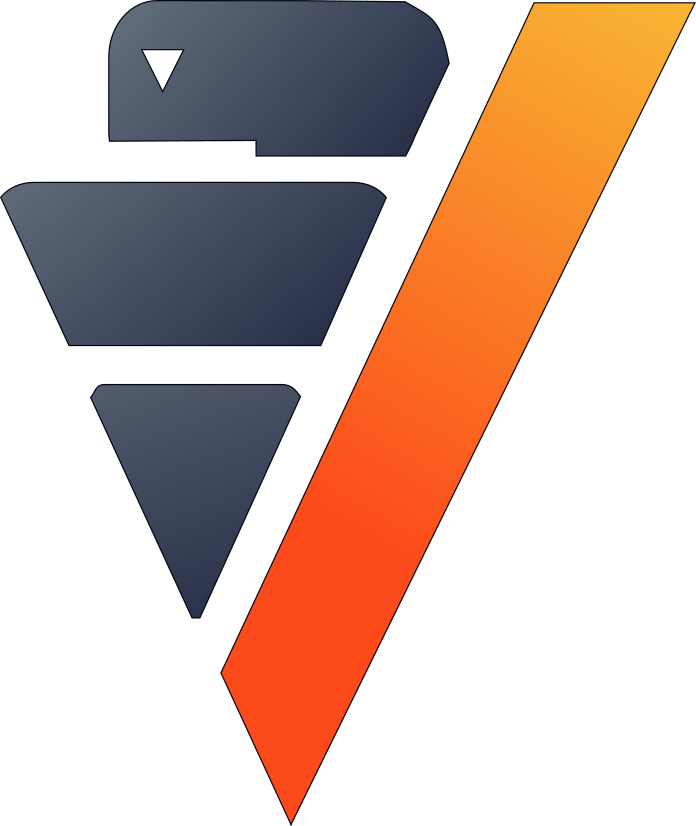

In [39]:
# Correlation matrix for tansformed data
pca_model.transform(n_components = 2)

### MCA : Multiple Correspondence Analysis

Multiple Correspondence Analysis (MCA) is a method that allows studying the association between two or more qualitative variables.

Let's apply [MCA](https://www.vertica.com/python/documentation_last/learn/MCA/index.php)

In [40]:
from verticapy.learn.decomposition import MCA
mca_model = MCA(name = "public.mca_titanic")

<AxesSubplot:xlabel='"dimensions"', ylabel='"percentage_explained_variance"'>

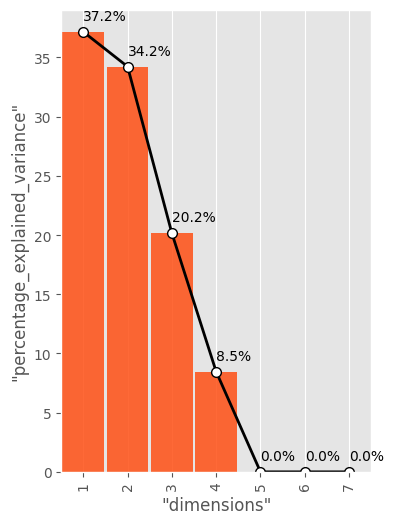

In [41]:
# Computing the Transformed Completely Disjontive Table before fitting the model
titanic = load_titanic()
tcdt = titanic[["survived", "pclass", "sex"]].cdt()
mca_model.fit(tcdt)
mca_model.plot_scree()

<AxesSubplot:xlabel='Dim1 (37.2%)', ylabel='Dim2 (34.2%)'>

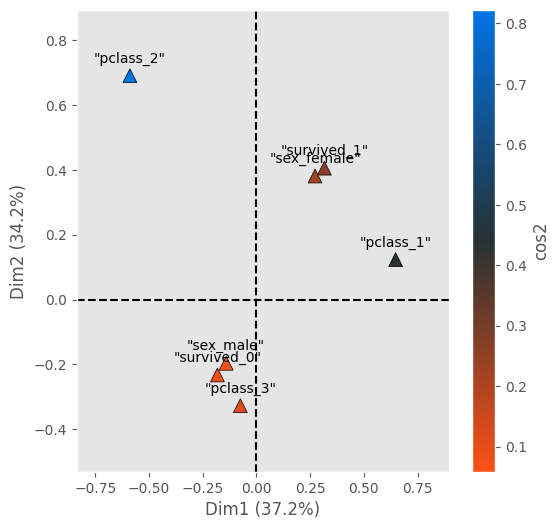

In [42]:
mca_model.plot_var(method="cos2")

col1                     col2                   col3                     col4                     col5                    col6                     col7  
1      0.00229204335572666      0.00032174051601326    0.00079733730833477     -0.00224766909385777    -3.23688558595547e-16    2.50613332170024e-16    -1.94722710178397e-16  
2      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
3      0.00229204335572666      0.00032174051601326    0.00079733730833477     -0.00224766909385777    -3.23688558595547e-16    2.50613332170024e-16    -1.94722710178397e-16  
4      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
5      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
6      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
7      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
8      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
9      0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
10     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
11     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
12     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
13     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
14     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
15     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
16     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
17     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
18     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
19     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
20     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
21     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16    -1.97162165066489e-16  
22     0.00146911605526506    -0.000826178800615678    0.00235861847839749    -0.000590677084986732     -3.2492183856675e-16     2.5221253037444e-16  
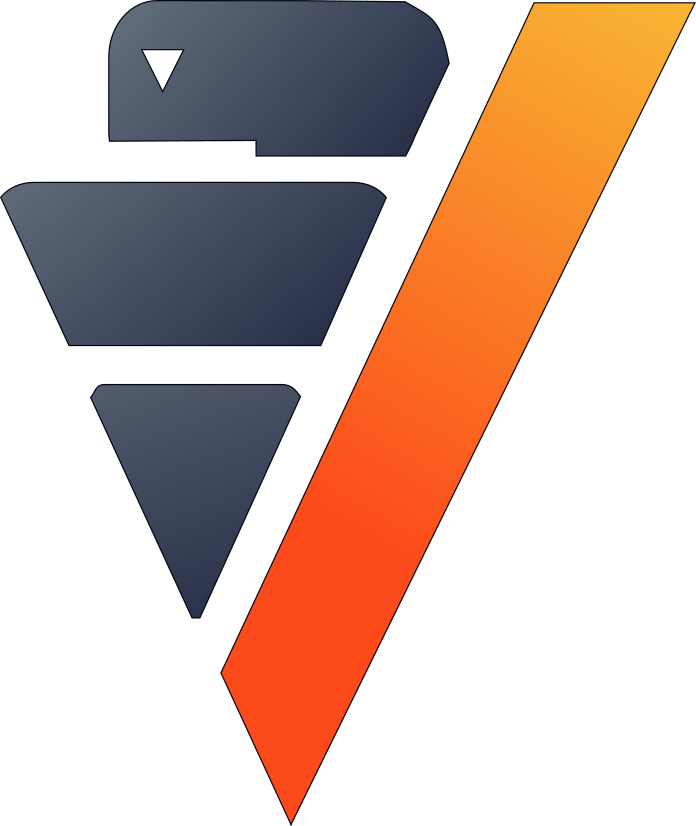

In [43]:
# transform the data
mca_model.transform()

## Normalization

It is called normalization, standardization, or rescaling.  
    
The goal of normalization is to change the values of numeric features to a common scale, without distorting differences in the ranges of values which leads to improvement of the performance and the training stability of the model. The features might have different units (age, time, distance,..), then some features might have higher range than the others, that will intrinsically influence the results specific for the distance-based algorithms. It gives equal weights/importance to each variable so that no single variable steers model performance in one direction just because they are bigger numbers.

There are three main normalization techniques:

<b>Z-Score :</b> We reduce and center the feature values using the average and standard deviation. This normalization is sensitive to outliers.

<b>Robust Z-Score :</b> We reduce and center the feature values using the median and the median absolute deviation. This normalization is robust to outliers.

<b>Min-Max :</b> We reduce the feature values by using a bijection to [0,1]. The max will reach 1 and the min will reach 0. This normalization is robust to outliers.


<div class="alert alert-block alert-warning">
In many circumstances, normalization is advantageous. It enhances the model's numerical stability and frequently reduces training time. Normalization, on the other hand, isn't necessarily a good thing. By assuming equal importance of features, it can affect the performance of distance-based clustering algorithms. Normalization is typically not a good idea if there are inherent importance differences between features.
</div>

We will continue to work with our Titanic dataset for showcase normalization. If we look at our dataset, we will realize that there two interesting numeric columns: age and fare. Let us have a look at them to see their scales:

age        fare  
1       2.0      151.55  
2      30.0      151.55  
3      25.0      151.55  
4      39.0         0.0  
5      71.0     49.5042  
6      47.0     227.525  
7      None      25.925  
8      24.0    247.5208  
9      36.0     75.2417  
10     25.0        26.0  
11     45.0        35.5  
12     42.0       26.55  
13     41.0        30.5  
14     48.0     50.4958  
15     None        39.6  
16     45.0       26.55  
17     None        31.0  
18     33.0         5.0  
19     28.0        47.1  
20     17.0        47.1  
21     49.0        26.0  
22     36.0       78.85  
23     46.0      61.175  
24     None         0.0  
25     27.0    136.7792  
26     None        52.0  
27     47.0     25.5875  
28     37.0     83.1583  
29     None       26.55  
30     70.0        71.0  
31     39.0     71.2833  
32     31.0        52.0  
33     50.0     106.425  
34     39.0        29.7  
35     36.0     31.6792  
36     None    221.7792  
37     30.0       27.75  
38     19.0       263.0  
39     64.0       263.0  
40     None       26.55  
41     None         0.0  
42     37.0        53.1  
43     47.0        38.5  
44     24.0        79.2  
45     71.0     34.6542  
46     38.0    153.4625  
47     46.0        79.2  
48     None        42.4  
49     45.0      83.475  
50     40.0         0.0  
51     55.0        93.5  
52     42.0        42.5  
53     None     51.8625  
54     55.0        50.0  
55     42.0        52.0  
56     None     30.6958  
57     50.0     28.7125  
58     46.0        26.0  
59     50.0        26.0  
60     32.5       211.5  
61     58.0        29.7  
62     41.0     51.8625  
63     None       26.55  
64     None     27.7208  
65     29.0        30.0  
66     30.0        45.5  
67     30.0        26.0  
68     19.0        53.1  
69     46.0     75.2417  
70     54.0     51.8625  
71     28.0     82.1708  
72     65.0       26.55  
73     44.0        90.0  
74     55.0        30.5  
75     47.0        42.4  
76     37.0        29.7  
77     58.0     113.275  
78     64.0        26.0  
79     65.0     61.9792  
80     28.5     27.7208  
81     None         0.0  
82     45.5        28.5  
83     23.0        93.5  
84     29.0        66.6  
85     18.0       108.9  
86     47.0        52.0  
87     38.0         0.0  
88     22.0    135.6333  
89     None     227.525  
90     31.0     50.4958  
91     None        50.0  
92     36.0      40.125  
93     55.0        59.4  
94     33.0       26.55  
95     61.0     262.375  
96     50.0        55.9  
97     56.0       26.55  
98     56.0     30.6958  
99     24.0        60.0  
100    None        26.0  
Rows: 1-100 | Columns: 2
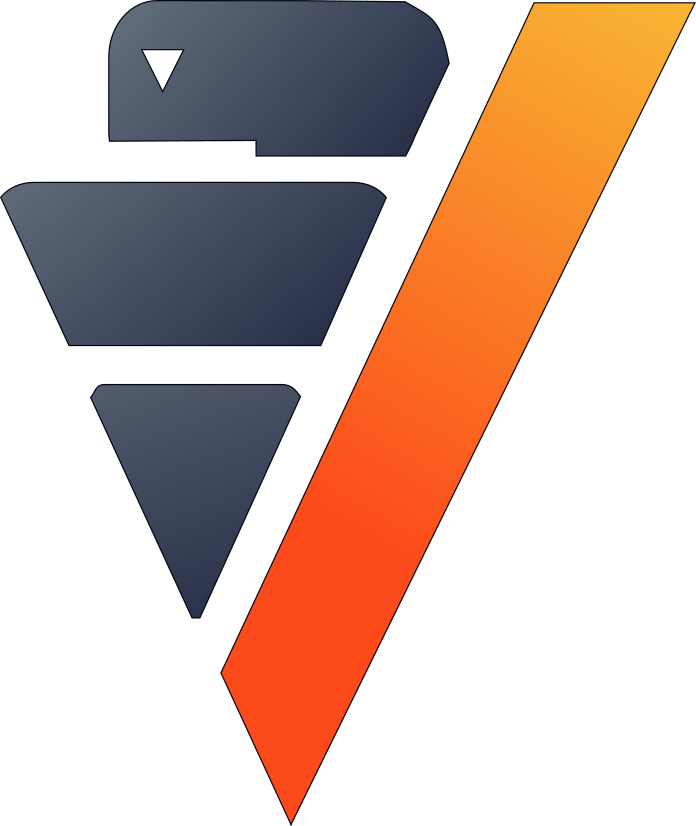

In [44]:
# display data
titanic.select(["age", "fare"])

These lie in different numerical intervals so it's probably a good idea to normalize them. To normalize data in VerticaPy, we can use the [`normalize`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/normalize/) method.

age                 fare  
1      0.020961466047446    0.295805899800363  
2       0.37241119618426    0.295805899800363  
3      0.309652315802686    0.295805899800363  
4      0.485377180871093                  0.0  
5      0.887034015313167    0.096625763278767  
6      0.585791389481612     0.44409922370226  
7                   None    0.050602229972447  
8      0.297100539726371    0.483128426019833  
9      0.447721852642149    0.146862017624605  
10     0.309652315802686    0.050748620223091  
11     0.560687837328982    0.069291385304605  
12     0.523032509100038     0.05182214872781  
13     0.510480733023723    0.059532035261703  
14     0.598343165557926    0.098561237579275  
15                  None    0.077294052339785  
16     0.560687837328982     0.05182214872781  
17                  None    0.060507970265993  
18     0.410066524413204    0.009759350042902  
19      0.34730764403163    0.091933077404138  
20     0.209238107192168    0.091933077404138  
21     0.610894941634241    0.050748620223091  
22     0.447721852642149    0.153904950176566  
23     0.573239613405297    0.119405647774907  
24                  None                  0.0  
25     0.334755867955316    0.266975218277623  
26                  None    0.101497240446182  
27     0.585791389481612    0.049943473844552  
28     0.460273628718464    0.162314191734533  
29                  None     0.05182214872781  
30     0.874482239236852     0.13858277060921  
31     0.485377180871093    0.139135735382641  
32     0.384962972260575    0.101497240446182  
33     0.623446717710556    0.207727765663171  
34     0.485377180871093    0.057970539254838  
35     0.447721852642149    0.061833680375821  
36                  None    0.432884169006959  
37      0.37241119618426    0.054164392738107  
38     0.234341659344797    0.513341812256651  
39     0.799171582778963    0.513341812256651  
40                  None     0.05182214872781  
41                  None                  0.0  
42     0.460273628718464     0.10364429745562  
43     0.585791389481612    0.075146995330346  
44     0.297100539726371    0.154588104679569  
45     0.887034015313167    0.067640493651348  
46     0.472825404794778    0.299538851191773  
47     0.573239613405297    0.154588104679569  
48                  None     0.08275928836381  
49     0.560687837328982    0.162932348966251  
50     0.497928956947408                  0.0  
51      0.68620559809213    0.182499845802269  
52     0.523032509100038    0.082954475364668  
53                  None    0.101228858320002  
54      0.68620559809213    0.097593500429021  
55     0.523032509100038    0.101497240446182  
56                  None    0.059914211409383  
57     0.623446717710556    0.056043067621365  
58     0.573239613405297    0.050748620223091  
59     0.623446717710556    0.050748620223091  
60     0.403790636375047    0.412820506814759  
61     0.723860926321074    0.057970539254838  
62     0.510480733023723    0.101228858320002  
63                  None     0.05182214872781  
64                  None    0.054107398133856  
65     0.359859420107945    0.058556100257413  
66      0.37241119618426    0.088810085390409  
67      0.37241119618426    0.050748620223091  
68     0.234341659344797     0.10364429745562  
69     0.573239613405297    0.146862017624605  
70     0.673653822015815    0.101228858320002  
71      0.34730764403163     0.16038672010106  
72     0.811723358855278     0.05182214872781  
73     0.548136061252667    0.175668300772238  
74      0.68620559809213    0.059532035261703  
75     0.585791389481612     0.08275928836381  
76     0.460273628718464    0.057970539254838  
77     0.723860926321074    0.221098075221947  
78     0.799171582778963    0.050748620223091  
79     0.811723358855278    0.120975341635808  
80     0.353583532069788    0.054107398133856  
81                  None                  0.0  
82     0.566963725367139    0.055628295244542  
83     0.284548763650056    0.1824998
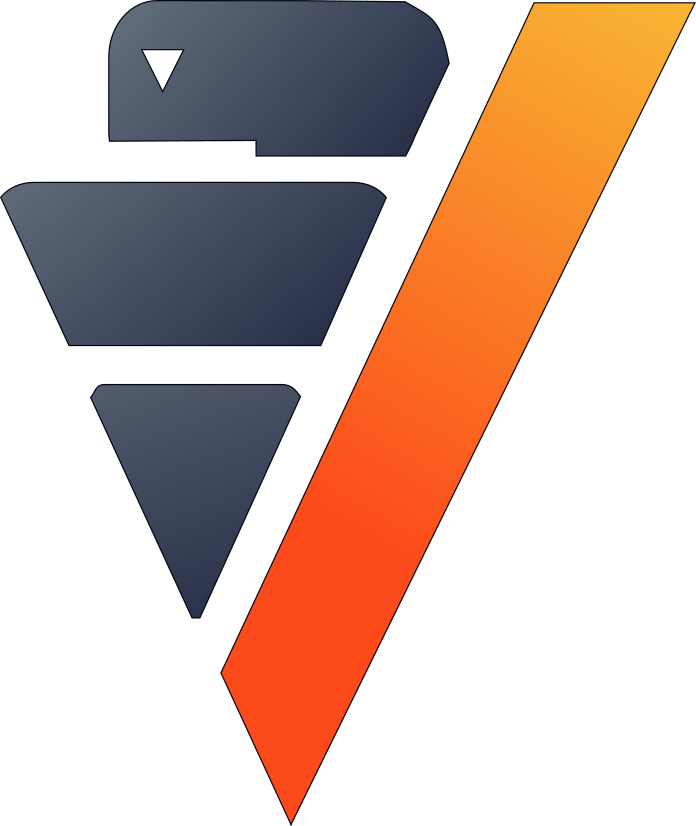

In [45]:
# normalize age and fare with minmax
titanic["age"].normalize(method="minmax")  # method = zscore, robust_zscore
titanic["fare"].normalize(method="minmax")  # method = zscore, robust_zscore
titanic.select(["age", "fare"])

## Data Balancing


Unbalanced data is a common issue in data science and it affect the accuracy of the models. To solve this problem, there two ways either `downsampling` or `upsampling`. Let's use [`balance`](https://www.vertica.com/python/documentation_last/vdataframe/main-methods/balance/index.php) to perform these techniques.

count    percent  
S            873     70.746  
C            253     20.502  
Q            106       8.59  
Rows: 1-3 | Columns: 3
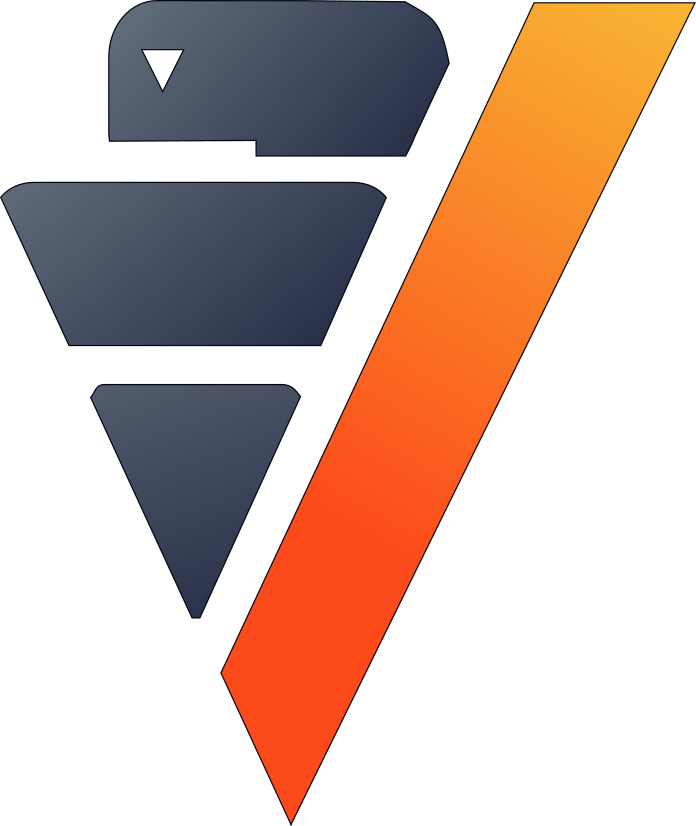

In [46]:
# top values
titanic['embarked'].topk()

count    percent  
Q            106     33.333  
C            106     33.333  
S            106     33.333  
Rows: 1-3 | Columns: 3
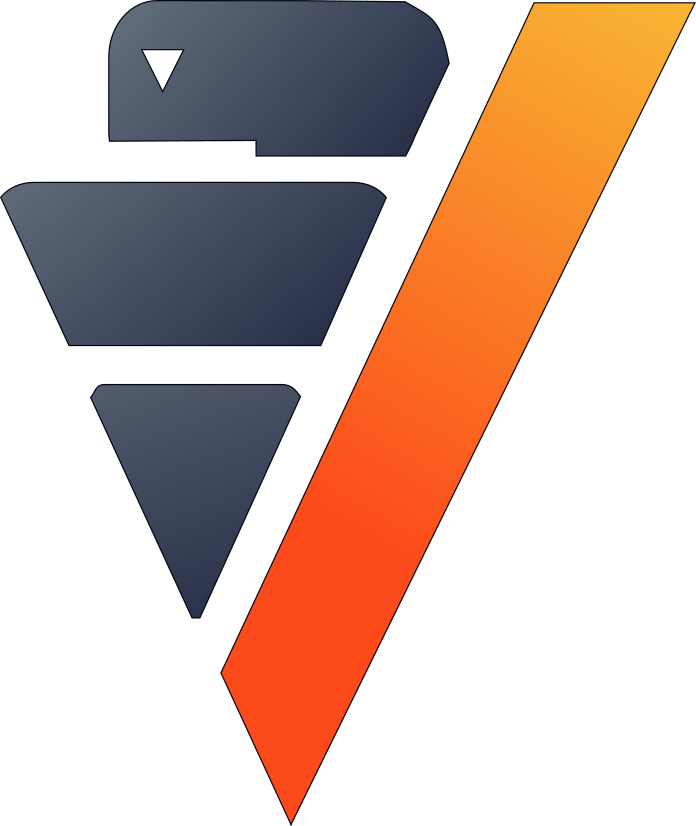

In [47]:
# hybrid
hybrid_balance = titanic.balance(column="embarked")
hybrid_balance["embarked"].topk()

count    percent  
Q            106     38.406  
S             85     30.797  
C             85     30.797  
Rows: 1-3 | Columns: 3
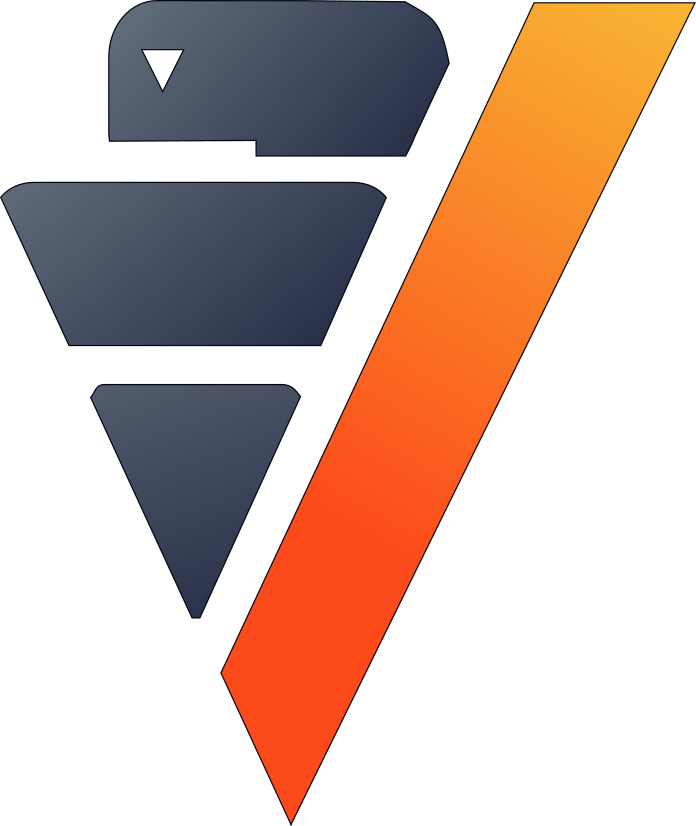

In [48]:
# over
over_balance = titanic.balance(column="embarked", method="over", x=0.8)
over_balance["embarked"].topk()

count    percent  
S            212       40.0  
C            212       40.0  
Q            106       20.0  
Rows: 1-3 | Columns: 3
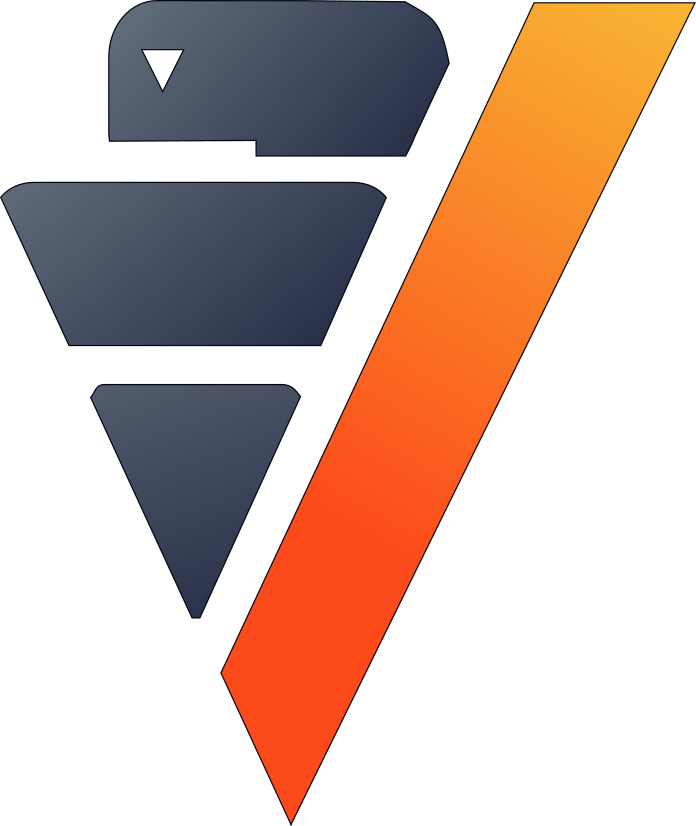

In [49]:
# under
under_balance = titanic.balance(column="embarked", method="under", x=0.5)
under_balance["embarked"].topk()